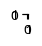

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import itertools
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

# merged?

In [238]:
merged=pd.read_csv('../data/pepx/231018_cedar_prime_merged_fold.csv')

In [244]:
merged.query('not (in_cedar and in_prime)').to_csv('../data/pepx/231106_cedar_prime_no_overlap.csv',index=False)

In [245]:
merged.query('(in_cedar and in_prime)').to_csv('../data/pepx/231106_overlap.csv',index=False)

# Redo Models comparison fig without consensus model

In [3]:
def get_fi(fn_dict, key, pdir='../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/'):
    fn = f"featimps_{fn_dict[key]}.csv"
    return pd.read_csv(f'{pdir}{fn}')

def get_pred(evalset, fn_dict, key, pdir='../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/'):
    fn = f"{evalset}_preds_{fn_dict[key]}.csv"
    print(pdir + fn,'\n')
    return pd.read_csv(f'{pdir}{fn}')

cedar_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')

base_model = 'cedar_onehot_None_icore_mut_only_rank'
best_cedar = 'cedar_onehot_Inv-KL_icore_mut_boman-blsm_mut_score-EL_rank_wt_aligned-foreignness_score-Total_Gene_TPM'
best_prime = 'cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-ratio_rank-Total_Gene_TPM'
harmonic = 'cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM'
compromise = 'cedar_onehot_None_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM'
fn_dict = {'base_model':base_model, 'best_cedar':best_cedar, 'best_prime':best_prime, 'harmonic':harmonic, 'compromise':compromise}

best_models = {k:{} for k in fn_dict.keys()}
for k in best_models:
    best_models[k]['featimp'] = get_fi(fn_dict, k)

In [4]:
best_models[k]

{'featimp':           A         R         N         D         C         Q         E  \
 0  0.020963  0.017873  0.011423  0.021914  0.006762  0.016429  0.019456   
 
           G        H         I  ...        P         S         T         W  \
 0  0.015776  0.01666  0.051474  ...  0.02623  0.047917  0.021129  0.011346   
 
           Y         V      rank  icore_dissimilarity_score  \
 0  0.040106  0.043877  0.196533                   0.093611   
 
    icore_blsm_mut_score  Total_Gene_TPM  
 0              0.041905        0.112227  
 
 [1 rows x 24 columns]}

In [5]:
from src.metrics import roc_auc_score
bslmrg = ['Peptide','HLA', 'agg_label', 'EL_rank_mut']

new_nnalign_cedar = pd.read_csv('../../nnalign_cedar/baseline/output_baseline/2305XX_cedar_fold.pep_9174/2305XX_cedar_fold.pep_9174.lg5.sorted.pred', sep='\t').rename(columns={'Prediction':'NNAlign_New'})
new_nnalign_cedar['agg_label'] = new_nnalign_cedar['Measure'].astype(int)

new_nnalign_prime = pd.read_csv('../../benchmark/results/nnalign_newbaseline_lgt5_EVAL_PRIME.txt', sep='\t').rename(columns={'Prediction':'NNAlign_New'})
new_nnalign_prime['agg_label'] = new_nnalign_prime['Measure'].astype(int)

new_nnalign_nepdb = pd.read_csv('../../benchmark/results/nnalign_newbaseline_lgt5_EVAL_NEPDB.txt', sep='\t').rename(columns={'Prediction':'NNAlign_New'})
new_nnalign_nepdb['agg_label'] = new_nnalign_nepdb['Measure'].astype(int)

In [6]:
print('New NNAlign roc scores')
print('cedar', round(roc_auc_score(new_nnalign_cedar['agg_label'], new_nnalign_cedar['NNAlign_New']), 7))
print('prime', round(roc_auc_score(new_nnalign_prime['agg_label'], new_nnalign_prime['NNAlign_New']), 7))
print('nepdb', round(roc_auc_score(new_nnalign_nepdb['agg_label'], new_nnalign_nepdb['NNAlign_New']), 7))

New NNAlign roc scores
cedar 0.6906559
prime 0.6934246
nepdb 0.4383494


In [9]:
cedar_expr_baseline = pd.merge(cedar_baseline[[x for x in cedar_baseline.columns if x not in cedar_aligned_expr.columns or x in bslmrg]], cedar_aligned_expr, left_on=bslmrg, right_on=bslmrg)

assert (new_nnalign_cedar.sort_values(['Peptide','Measure'])['Peptide'].values == cedar_expr_baseline.sort_values(['Peptide','agg_label'])['Peptide'].values).all() and \
       (new_nnalign_cedar.sort_values(['Peptide','Measure'])['agg_label'].values == cedar_expr_baseline.sort_values(['Peptide','agg_label'])['agg_label'].values).all(), 'xd'
cedar_expr_baseline =  pd.merge(new_nnalign_cedar, cedar_expr_baseline, left_on=['Peptide', 'agg_label'], right_on=['Peptide','agg_label']).drop_duplicates(subset=['Peptide','HLA','agg_label']).rename(columns = {'NNAlign_New':'NNAlign_score_new'})


prime_expr_baseline = pd.merge(prime_baseline[[x for x in prime_baseline.columns if x not in prime_aligned_expr.columns or x in bslmrg]], prime_aligned_expr, left_on=bslmrg, right_on=bslmrg)

assert (new_nnalign_prime.sort_values(['Peptide','Measure'])['Peptide'].values == prime_expr_baseline.sort_values(['Peptide','agg_label'])['Peptide'].values).all() and \
       (new_nnalign_prime.sort_values(['Peptide','Measure'])['agg_label'].values == prime_expr_baseline.sort_values(['Peptide','agg_label'])['agg_label'].values).all(), 'xd'
prime_expr_baseline = pd.merge(prime_expr_baseline.sort_values(['Peptide','agg_label']), new_nnalign_prime.sort_values(['Peptide','Measure'])[['NNAlign_New']], left_index=True, right_index=True).rename(columns = {'NNAlign_New':'NNAlign_score_new'})

In [10]:
print(round(roc_auc_score(cedar_expr_baseline['agg_label'], cedar_expr_baseline['NNAlign_score_new']),7)==round(roc_auc_score(new_nnalign_cedar['agg_label'], new_nnalign_cedar['NNAlign_New']), 7))
print(round(roc_auc_score(prime_expr_baseline['agg_label'], prime_expr_baseline['NNAlign_score_new']),7)==round(roc_auc_score(new_nnalign_prime['agg_label'], new_nnalign_prime['NNAlign_New']), 7))

True
True


In [11]:
# Reget preds 
cp_common_peps = [x for x in cedar_expr_baseline.Peptide.values if x in prime_expr_baseline.Peptide.values]
rebootstrapped_best = {}
for evalset, df_baseline in zip(['cedar', 'prime'],
                            [cedar_expr_baseline, prime_expr_baseline]):
    tmp = []
    for k in best_models:
        if evalset=='prime':
            best_models[k][evalset] = get_pred(evalset, fn_dict, k).query('Peptide not in @cp_common_peps')
        else:
            best_models[k][evalset] = get_pred(evalset, fn_dict, k)
            
        pcol = 'pred' if 'pred' in best_models[k][evalset].columns else 'mean_pred'
        scores = best_models[k][evalset][pcol].values
        labels = best_models[k][evalset]['agg_label'].astype(int).values
        bootstrapped_df = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8).assign(evalset=evalset, key=k)
        print(k,evalset, 'mean:', round(bootstrapped_df['auc'].mean(),4), 'median:',round(bootstrapped_df['auc'].median(),4))
        tmp.append(bootstrapped_df)
        
    peps=best_models[k][evalset].Peptide.values
    if evalset=='prime':
        evalset_copy = df_baseline.query('Peptide not in @cp_common_peps and Peptide in @peps')
    else:
        evalset_copy = df_baseline.copy('Peptide in @peps')
    # Bootstrap PRIME and NN align as baseline on the boxplots?    
    for baseline in list(filter( lambda x: 'score' in x.lower() and ('prime' in x.lower() or 'nnalign' in x.lower()) , df_baseline.columns)):
        scores = evalset_copy[baseline].values
        labels = evalset_copy['agg_label'].astype(int).values
        bootstrapped_baseline = bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8).assign(evalset=evalset, key=baseline)
        tmp.append(bootstrapped_baseline)
    rebootstrapped_best[evalset] = pd.concat(tmp)


../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_None_icore_mut_only_rank.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
base_model cedar mean: 0.7194 median: 0.7194
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_Inv-KL_icore_mut_boman-blsm_mut_score-EL_rank_wt_aligned-foreignness_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
best_cedar cedar mean: 0.7417 median: 0.7418
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-ratio_rank-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
best_prime cedar mean: 0.7123 median: 0.7125
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
harmonic cedar mean: 0.7182 median: 0.7184
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/cedar_preds_cedar_onehot_None_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
compromise cedar mean: 0.7279 median: 0.728
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_None_icore_mut_only_rank.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
base_model prime mean: 0.693 median: 0.6944
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_Inv-KL_icore_mut_boman-blsm_mut_score-EL_rank_wt_aligned-foreignness_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
best_cedar prime mean: 0.6539 median: 0.6548
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-ratio_rank-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
best_prime prime mean: 0.7214 median: 0.7225
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_KL-Mask_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
harmonic prime mean: 0.7208 median: 0.7219
../../CEDAR_OUTPUTS/230427_FINAL_ANALYSIS_ALL/raw/prime_preds_cedar_onehot_None_icore_mut_dissimilarity_score-blsm_mut_score-Total_Gene_TPM.csv 

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
compromise prime mean: 0.7097 median: 0.7109
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [12]:
display(rebootstrapped_best['cedar'].groupby('key').agg(mean_auc=('auc', 'mean'),
                                                mean_auc01=('auc_01','mean')))
display(rebootstrapped_best['prime'].groupby('key').agg(mean_auc=('auc', 'mean'),
                                                mean_auc01=('auc_01','mean')))


mean_auc  mean_auc01
key                                    
NNAlign_score_new  0.690832    0.550090
PRIME_score        0.659433    0.541878
base_model         0.719448    0.581625
best_cedar         0.741664    0.586496
best_prime         0.712337    0.569128
compromise         0.727866    0.576827
harmonic           0.718216    0.568988
nnalign_score      0.680962    0.554611

mean_auc  mean_auc01
key                                    
NNAlign_score_new  0.631818    0.531504
PRIME_score        0.709605    0.581538
base_model         0.692971    0.572050
best_cedar         0.653946    0.530852
best_prime         0.721371    0.615861
compromise         0.709702    0.576791
harmonic           0.720788    0.599151
nnalign_score      0.608276    0.519226

In [13]:
def rename_models(key):
    return {'base_model': 'Base Model',
            'best_cedar' : 'Optimal CEDAR Model',
            'best_prime': 'Optimal PRIME Model',
            'harmonic': 'Consensus Model',
            'compromise': 'Compromise Model',
            'nnalign_score':'NNAlign',
            'NNAlign_score_new': 'NNAlign_New',
            'PRIME_score': 'PRIME'}[key]

rebootstrapped_best['cedar']['Model'] = rebootstrapped_best['cedar']['key'].apply(rename_models)
rebootstrapped_best['prime']['Model'] = rebootstrapped_best['prime']['key'].apply(rename_models)


In [149]:
sns.set_style('darkgrid')

0.0
9.999999999998899e-05


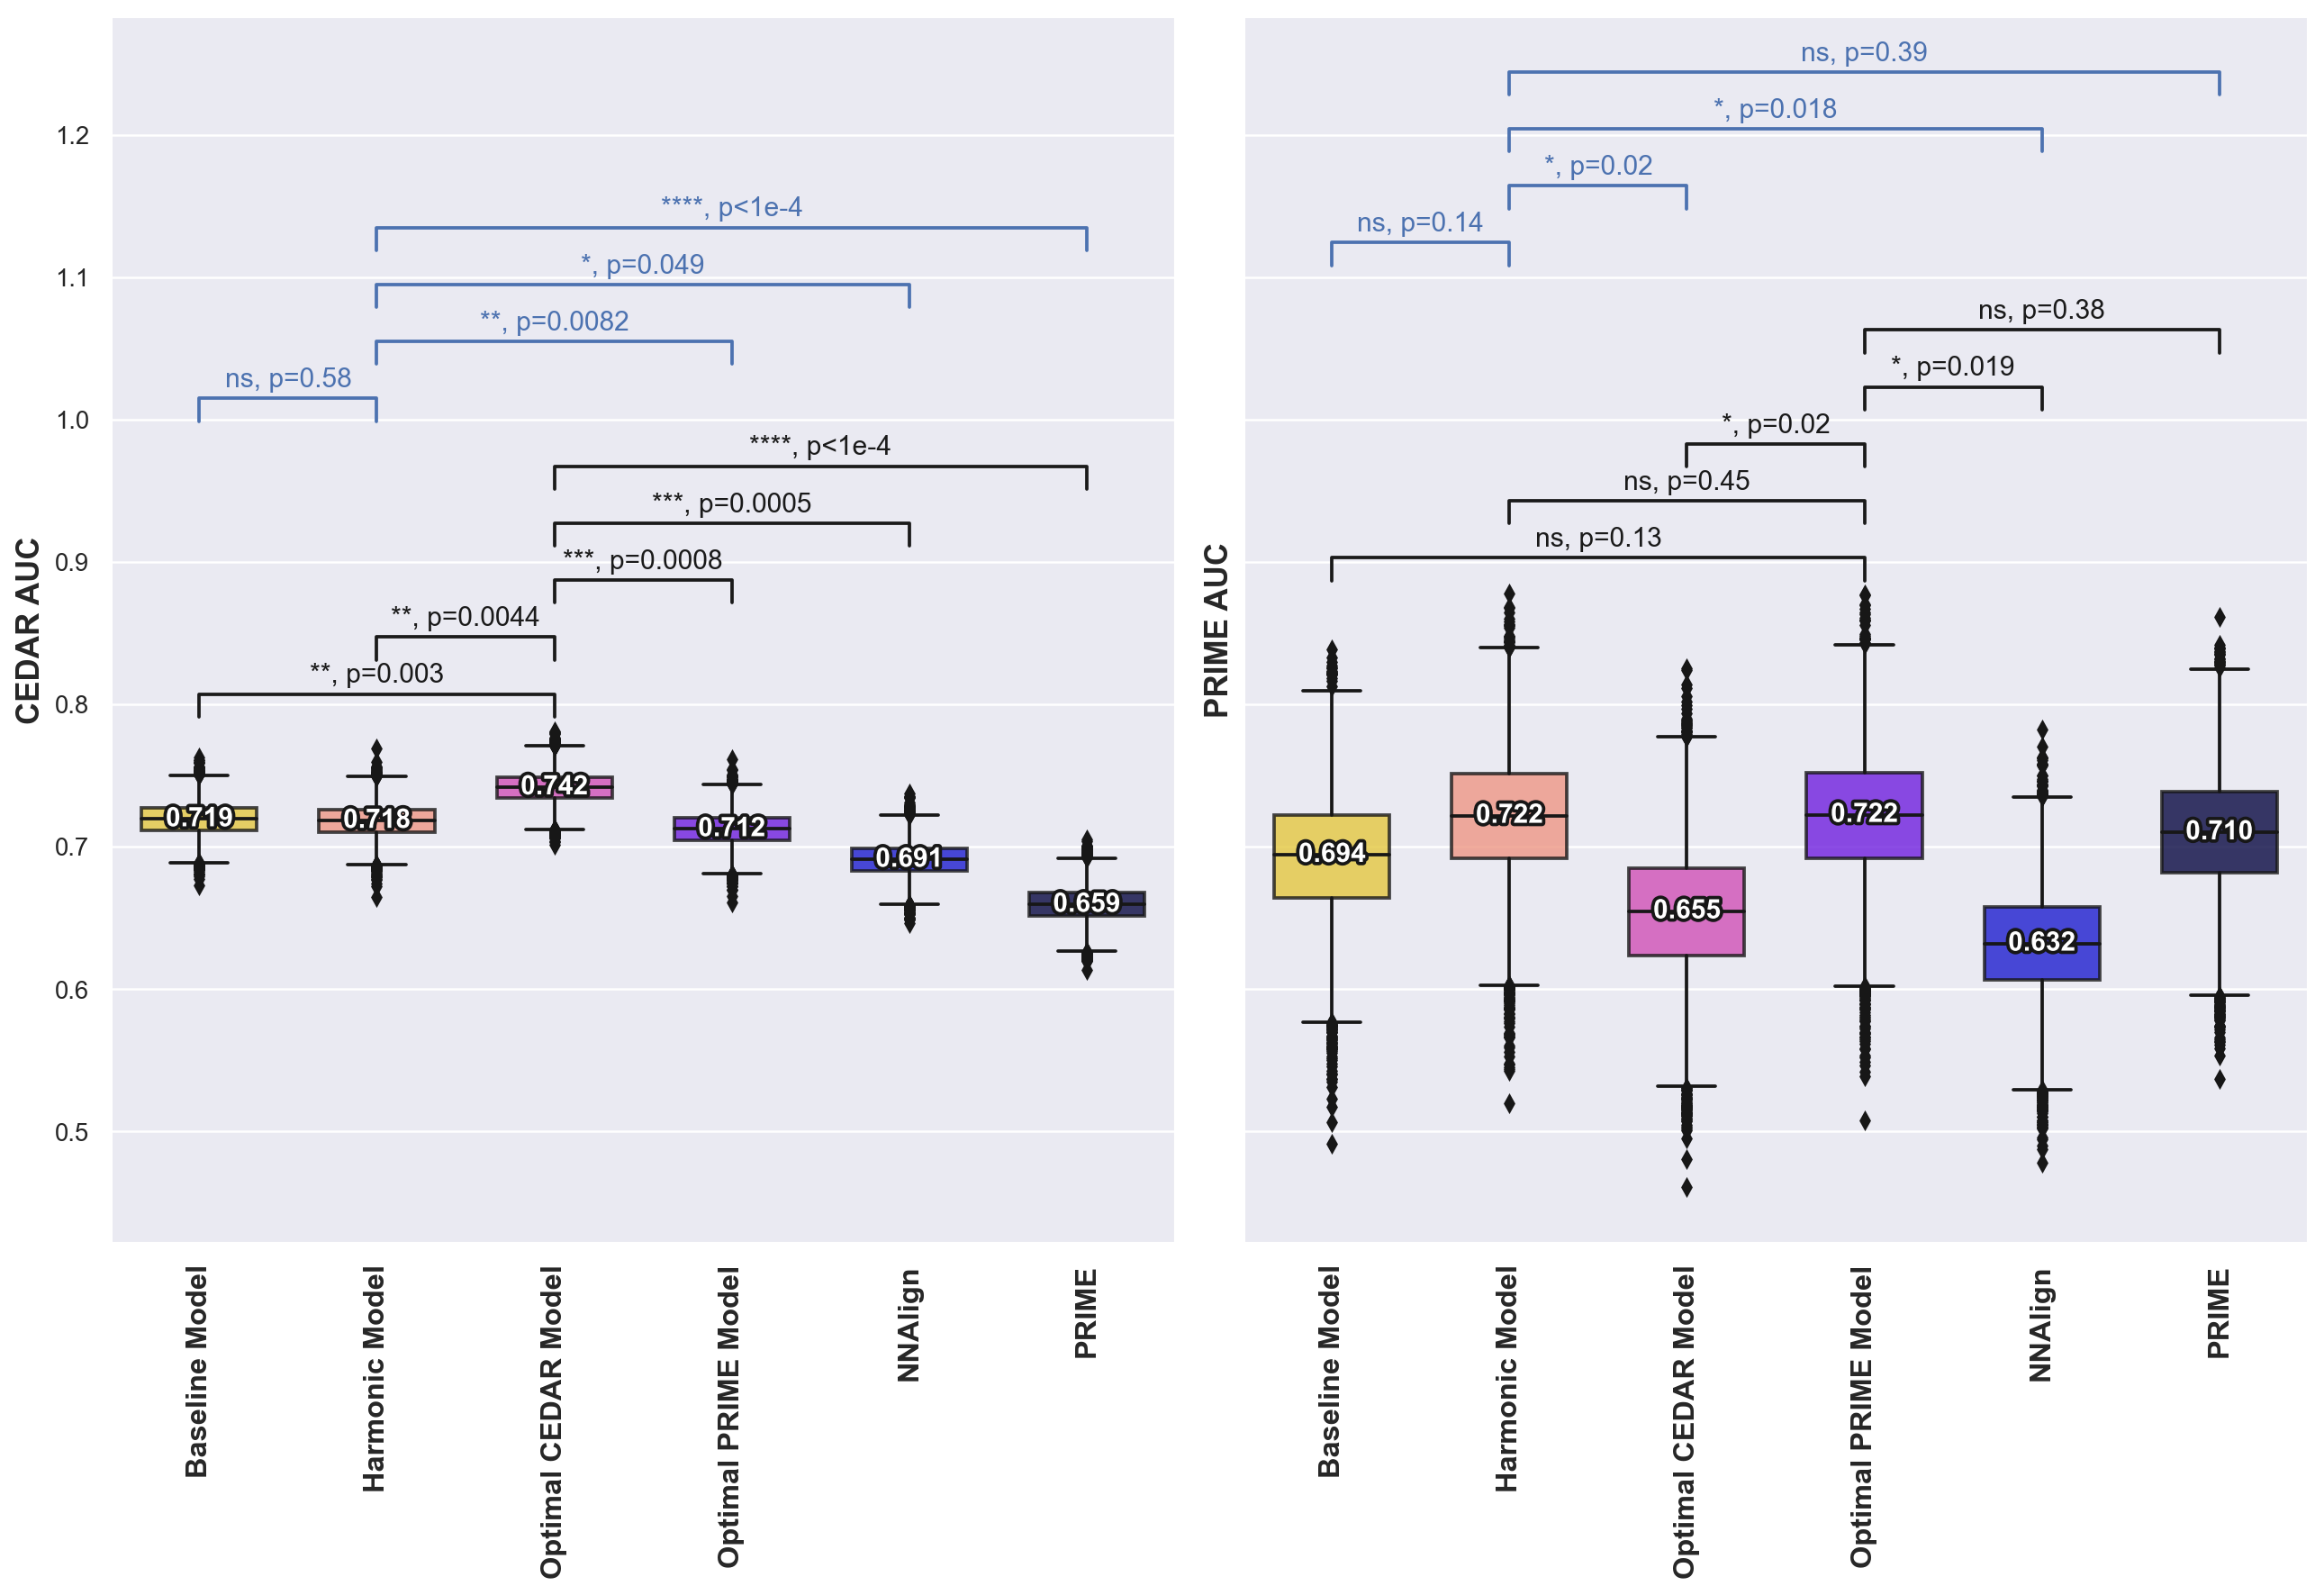

In [1348]:
from src.bootstrap import get_pval, plot_pval, get_pval_wrapper
sns.set_style('darkgrid')
# Redo the plot but keeping the order and redo not all the p-values, using the new features (i.e. including foreignness score etc)
f,a = plt.subplots(1,2, figsize=(14.5,10), sharey=True)
order = ['Baseline Model','Harmonic Model', 'Optimal CEDAR Model', 'Optimal PRIME Model', 'NNAlign', 'PRIME']

color_order = {k:v for k,v in zip(order, get_palette('gnuplot2_r', n_colors=len(order)))}
for evalset,axis in zip(rebootstrapped_best, a):
    tmp = rebootstrapped_best[evalset].copy().replace({'NNAlign_New':'NNAlign', 'Base Model': 'Baseline Model'}).query('key!="nnalign_score"')
    sorted_order = tmp.groupby('Model').agg(mean_auc=('auc','mean'))\
                      .sort_values('mean_auc', ascending=False).index.tolist()
    # Sort order by decreasing performance
    sns.boxplot(data = tmp , x = 'Model', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = order, hue_order=order, hue = 'Model', dodge=False)
    # Add median and remove legend / ylabel
    add_median_labels(axis, fmt = '.3f');
    axis.set_ylabel(f'{evalset.upper()} AUC', fontweight='semibold', fontsize=14);
    axis.set_xlabel('');
    axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', 
                         fontsize=13, rotation=90, ha='center')
    # axis.set_xticklabels([])
    # axis.set_title(f'Performance of models on {evalset.upper()} ', fontweight='semibold')
    # Comparing with aucs_base, which is the best one
    best = f'Optimal {evalset.upper()} Model'
    aucs_base = tmp.query('Model == @best')
    h, h0 = 0.01, 0.02
    x0 = order.index(best)
    plt.setp(axis.patches, alpha=0.8)
    comp_list = reversed([x for x in order if x != best]) if x0 >= 4 else [x for x in order if x != best]
    for i, comparison in enumerate(comp_list):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('Model == @comparison')
        pval, sig = get_pval_wrapper(aucs_base, aucs_comp)
        # print(evalset,best, 'here',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base.auc)+h, h=h0, color='k')
        h += 2 * h0
        
    # Comparing "agg_selection" with the lower 2
    new_order = [x for x in order if x != best and x != 'Harmonic Model']
    new_order = ['Harmonic Model'] + new_order
    aucs_har = tmp.query('Model == "Harmonic Model"')
    x0 = order.index('Harmonic Model')
    h += 1*h0
    for i, comparison in enumerate(new_order[1:]):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('Model == @comparison')
        pval, sig = get_pval_wrapper(aucs_har, aucs_comp)
        # print(evalset,best, 'there',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_har.auc)+h, h=h0, color = 'b')
        h += 2*h0
# a[0].set_ylabel('AUC', fontweight='semibold', fontsize=13);

# Just re-order legend because it got messed up for some reasons
# h, l = a[1].get_legend_handles_labels()
# new_h = [h.pop(l.index('Base Model')), h.pop(l.index('Harmonic Model'))]
# new_l = [l.pop(l.index('Base Model')), l.pop(l.index('Harmonic Model'))]
# new_h.extend(h)
# new_l.extend(l)

bbox = (0, 0.59)
a[0].legend([], frameon=False);
a[1].legend([], frameon=False);
# a[1].legend(bbox_to_anchor = bbox,prop=dict(weight='semibold', size = 14));
f.tight_layout()
# NUMBER PRINTED IS NOT THE MEAN BUT THE MEDIAN THAT'S WHY THEY ARE DIFFERENT FROM THE DF
f.savefig('../../../writing/230131_cedar_paper_1/figures/2305XX_FINAL_redone_best_models_compromise_WITHCEDARFILTERING.png', bbox_inches='tight', dpi=200)

0.0


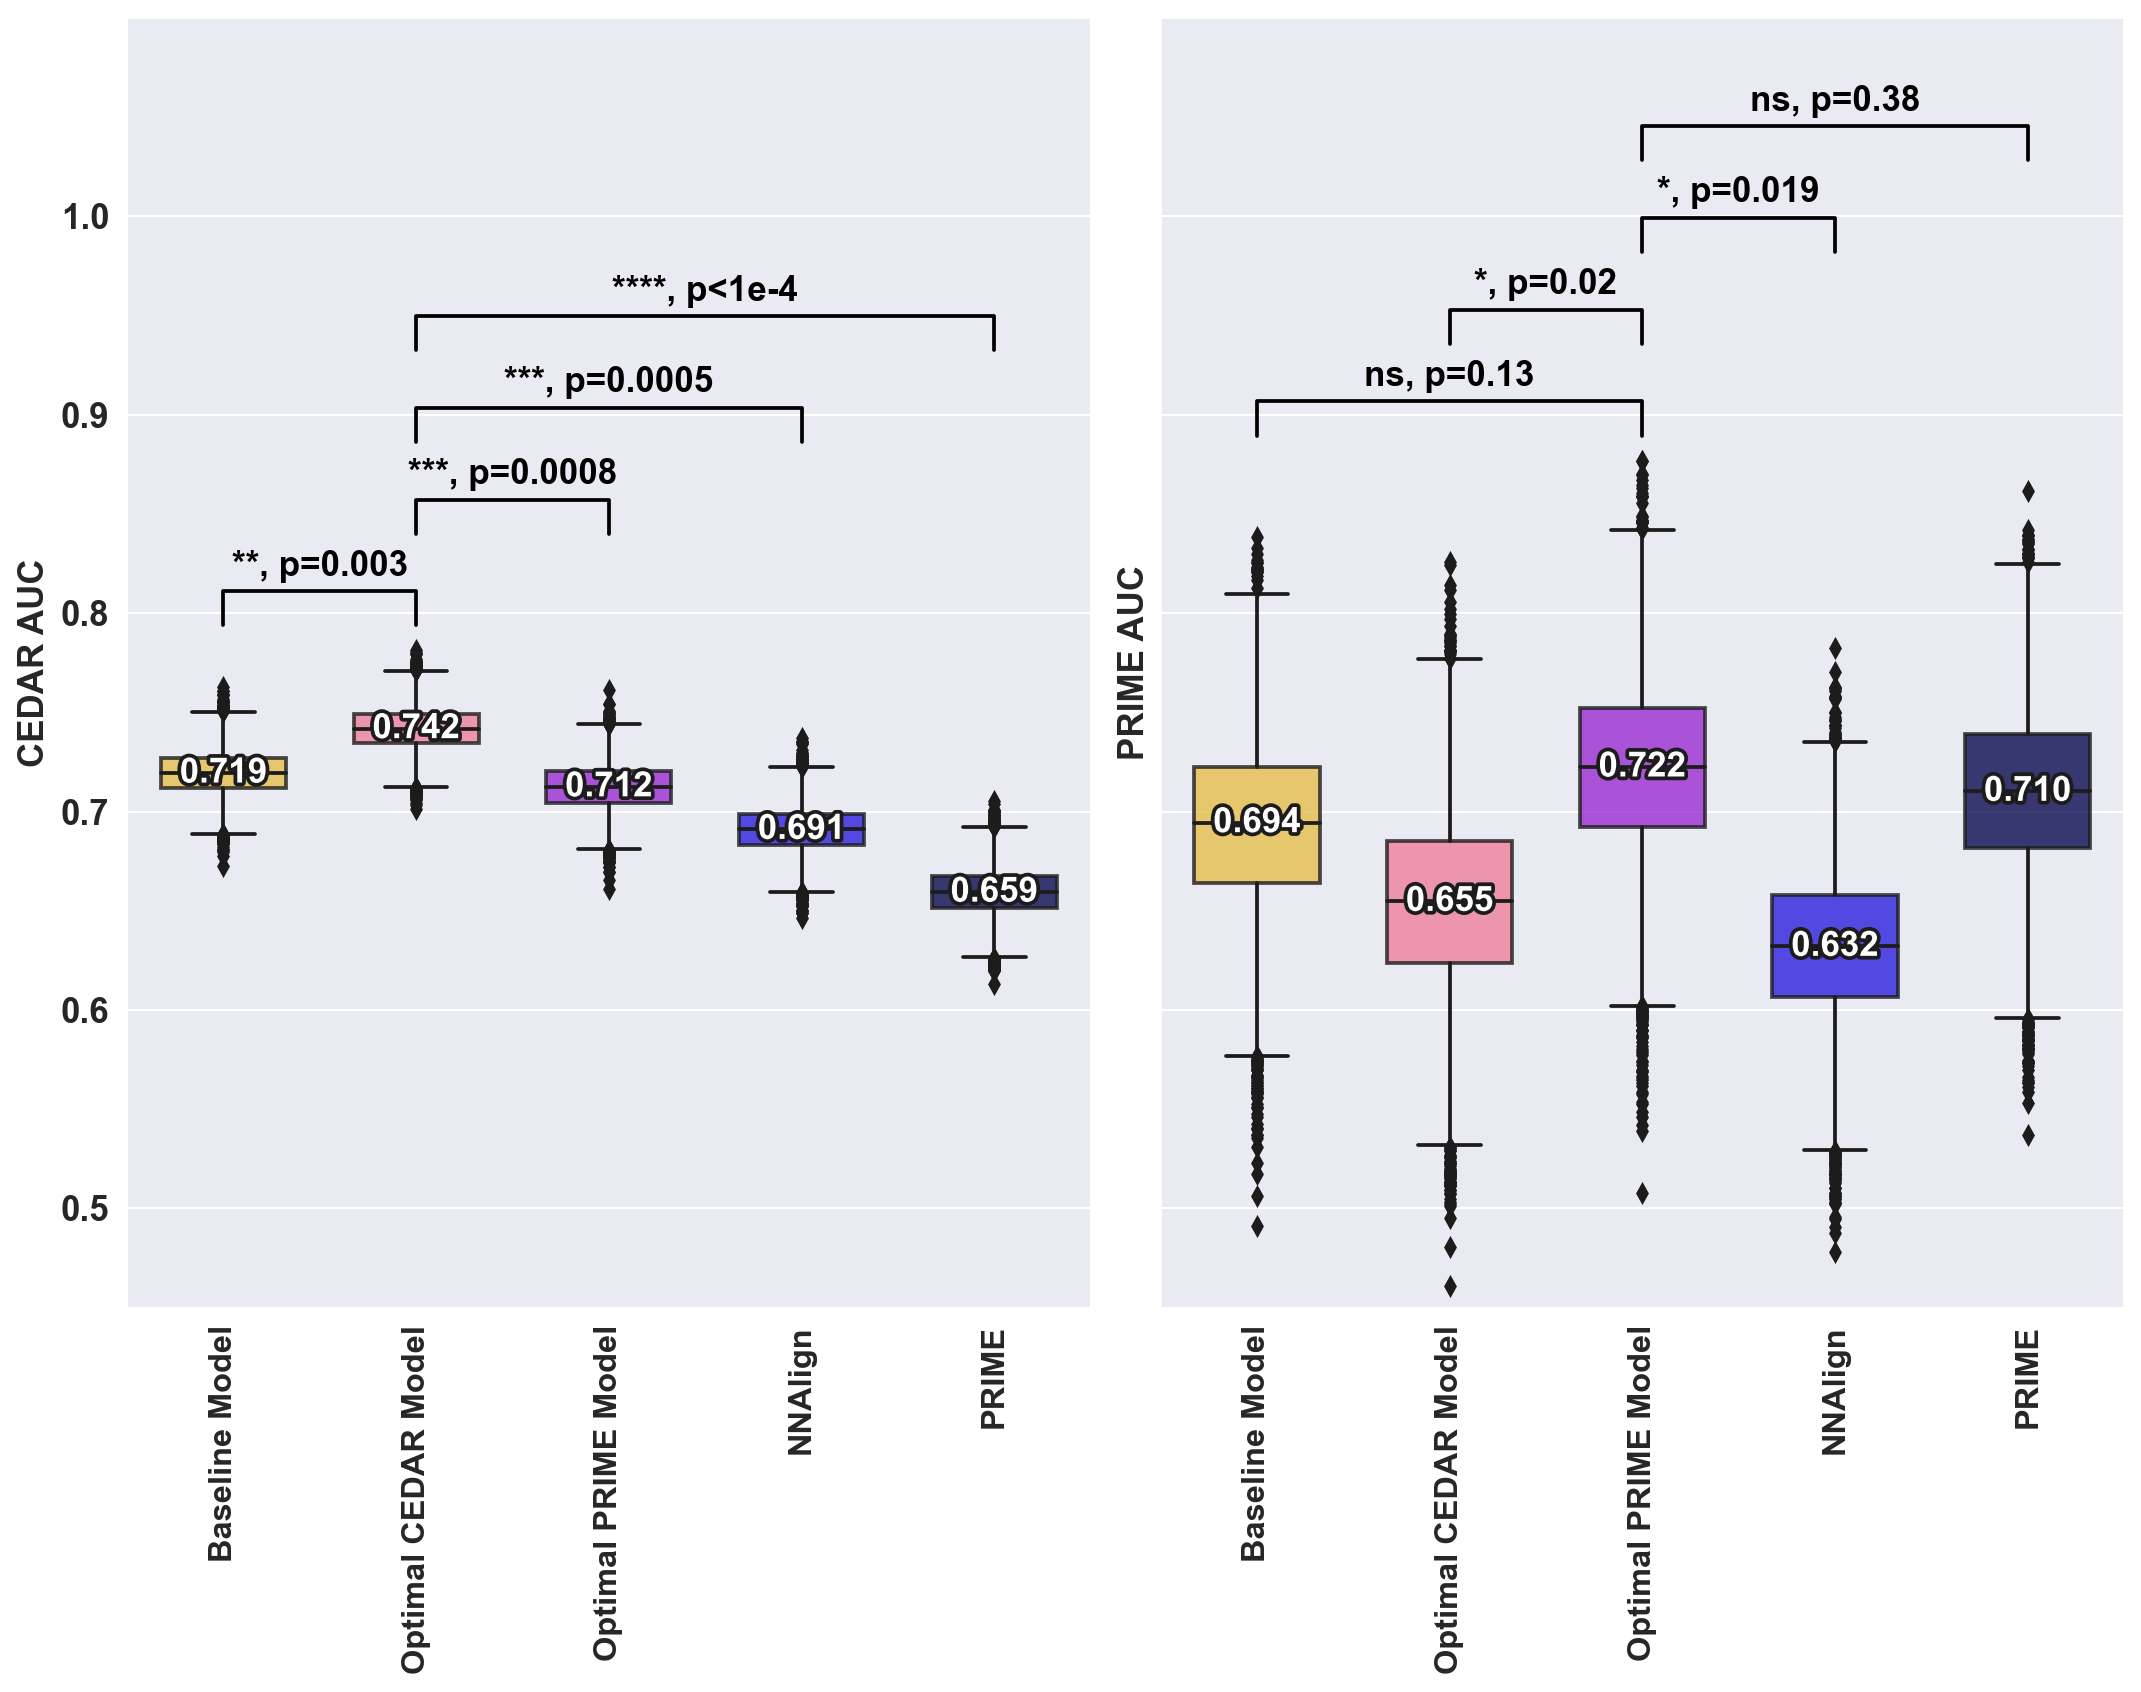

In [29]:
# REMAKE BIGGER
from src.bootstrap import get_pval, plot_pval, get_pval_wrapper
sns.set_style('darkgrid')
# Redo the plot but keeping the order and redo not all the p-values, using the new features (i.e. including foreignness score etc)
f,a = plt.subplots(1,2, figsize=(12,9.5), sharey=True)
order = ['Baseline Model', 'Optimal CEDAR Model', 'Optimal PRIME Model', 'NNAlign', 'PRIME']

color_order = {k:v for k,v in zip(order, get_palette('gnuplot2_r', n_colors=len(order)))}
for evalset,axis in zip(rebootstrapped_best, a):
    tmp = rebootstrapped_best[evalset].copy().replace({'NNAlign_New':'NNAlign', 
                                                       'Harmonic Model':'Consensus Model',
                                                       'Base Model': 'Baseline Model'}).query('key!="nnalign_score"')
    sorted_order = tmp.groupby('Model').agg(mean_auc=('auc','mean'))\
                      .sort_values('mean_auc', ascending=False).index.tolist()
    # Sort order by decreasing performance
    sns.boxplot(data = tmp , x = 'Model', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = order, hue_order=order, hue = 'Model', dodge=False)
    # Add median
    add_median_labels(axis, fmt = '.3f', fontsize=14);
    
    # Comparing with aucs_base, which is the best one
    best = f'Optimal {evalset.upper()} Model'
    aucs_base = tmp.query('Model == @best')
    h, h0 = 0.01265, 0.0215
    x0 = order.index(best)
    plt.setp(axis.patches, alpha=0.8)
    comp_list = reversed([x for x in order if x != best]) if x0 >= 4 else [x for x in order if x != best]
    for i, comparison in enumerate(comp_list):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('Model == @comparison')
        pval, sig = get_pval_wrapper(aucs_base, aucs_comp)        
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base.auc)+h, h=h0, 
                  fontweight='semibold', fontsize=14, color='k')
        h += 2.15 * h0
    # Adjust Y/X ticks
    axis.set_ylim([0.45, 1.1])
    yticks = np.arange(0.5, 1.05, 0.1)
    yticklabels = [f'{x:.1f}' for x in yticks]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels, fontweight='semibold', fontsize=14)
    axis.set_ylabel(f'{evalset.upper()} AUC', fontweight='semibold', fontsize=14);
    # axis.set_ylabel('');
    axis.set_xlabel('');
    axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', 
                         fontsize=13, rotation=90, ha='center')
    
# a[0].text(0.0055, 0.9425, 'A', fontsize=34, fontweight='bold', transform=a[0].transAxes)
# a[1].text(0.0055, 0.9425, 'B', fontsize=34, fontweight='bold', transform=a[1].transAxes)
 
bbox = (0, 0.59)
a[0].legend([], frameon=False);
a[1].legend([], frameon=False);f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/submission_nar/figures_redo/FIG6_bestmodels_redo.png',
                                                         bbox_inches='tight', dpi=600)

# Re-make / do viral featimp script thing with merged dataset

In [47]:
viral = pd.read_csv('../data/neoepi_viral/viral.csv')
cedar = pd.read_csv('../data/neoepi_viral/cedar.csv')
merged = pd.read_csv('../data/pepx/231018_cedar_prime_merged_fold.csv')

In [53]:
merged[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns = {'icore_mut':'sequence'})

sequence        HLA  EL_rank_mut  agg_label
0       AAAAAAAVL  HLA-B0702       0.9883          0
1       AAAAAAAVL  HLA-B0702       0.9883          0
2       AAAAAAQQI  HLA-B0702       3.9712          0
3       AAAALHMQR  HLA-A1101       0.3609          0
4       AAAAQQIQV  HLA-B0702       4.9092          0
...           ...        ...          ...        ...
5414  YYNFEGDIALL  HLA-A2402       0.6247          0
5415    YYPGKKEPF  HLA-A2402       0.0965          0
5416    YYSKNLNSF  HLA-A2402       0.0033          1
5417    YYSKNLNSF  HLA-A2402       0.0033          1
5418    YYSPQAQTL  HLA-A2402       0.0052          0

[5419 rows x 4 columns]

In [51]:
merged[['icore_mut','HLA', 'EL_rank_mut', 'agg_label']].rename(columns = {'icore_mut':'sequence'}).to_csv('../data/neoepi_viral/merged.csv', index=False)

In [58]:
viral_df = pd.read_csv('../output/231101_redo_viral_merged_dataset/feat_imps_df.csv')
viral_df.groupby(['Weight']).count()

A    R    N    D    C    Q    E    G    H    I  ...    Y    V  \
Weight                                                         ...             
Inverted-KL  260  260  260  260  260  260  260  260  260  260  ...  260  260   
KL           260  260  260  260  260  260  260  260  260  260  ...  260  260   
Mask         260  260  260  260  260  260  260  260  260  260  ...  260  260   
None         260  260  260  260  260  260  260  260  260  260  ...  260  260   

             rank  ProportionViral  NpepViral  seed  Proportion Viral  \
Weight                                                                  
Inverted-KL   260              260        260   260               260   
KL            260              260        260   260               260   
Mask          260              260        260   260               260   
None          260              260        260   260               260   

             Tryptophan (W) Feat. Importance  kcv_auc  neoepi_auc  
Weight                                                             
Inverted-KL                              260      260         260  
KL                                       260      260         260  
Mask                                     260      260         260  
None                                     260      260         260  

[4 rows x 28 columns]

In [60]:
viral_df.replace({'Inverted-KL': 'IC', 'KL':'(1-IC)'}, inplace=True)

In [59]:
viral_df['Proportion Viral'] = viral_df.apply(lambda x: f"{x['ProportionViral']/100:.1%}", axis=1)
viral_df['Tryptophan (W) Feat. Importance'] = viral_df.apply(lambda x: 100*x['W'], axis=1)
viral_df.groupby(['Proportion Viral', 'Weight']).agg(mean_W_imp=('W','mean'))

mean_W_imp
Proportion Viral Weight                 
0.0%             Inverted-KL    0.011336
                 KL             0.019950
                 Mask           0.018273
                 None           0.018313
16.7%            Inverted-KL    0.019669
...                                  ...
71.4%            None           0.065785
9.1%             Inverted-KL    0.016166
                 KL             0.023235
                 Mask           0.019836
                 None           0.020388

[104 rows x 1 columns]

In [66]:
human_df = pd.read_csv('../../CEDAR_OUTPUTS/230426_human_featimp/feat_imps_df.csv')
print(human_df.columns)
human_df.head()
human_df.replace({'Inverted-Shannon':'IC'}, inplace=True)

Index(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F',
       'P', 'S', 'T', 'W', 'Y', 'V', 'rank', 'Proportionhuman', 'Npephuman',
       'Weight', 'seed', 'Proportion human', 'Tryptophan (W) Feat. Importance',
       'kcv_auc', 'neoepi_auc'],
      dtype='object')


In [67]:
human_df['Proportion Human'] = human_df.apply(lambda x: f"{x['Proportionhuman']/100:.1%}", axis=1)
human_df['Tryptophan (W) Feat. Importance'] = human_df.apply(lambda x: 100*x['W'], axis=1)
human_df.groupby(['Proportion Human', 'Weight']).agg(mean_W_imp=('W','mean'))

mean_W_imp
Proportion Human Weight            
0.0%             IC        0.009681
                 Mask      0.020581
                 None      0.016084
16.7%            IC        0.009466
                 Mask      0.019914
...                             ...
90.7%            Mask      0.016134
                 None      0.012198
90.8%            IC        0.009342
                 Mask      0.016108
                 None      0.012053

[297 rows x 1 columns]

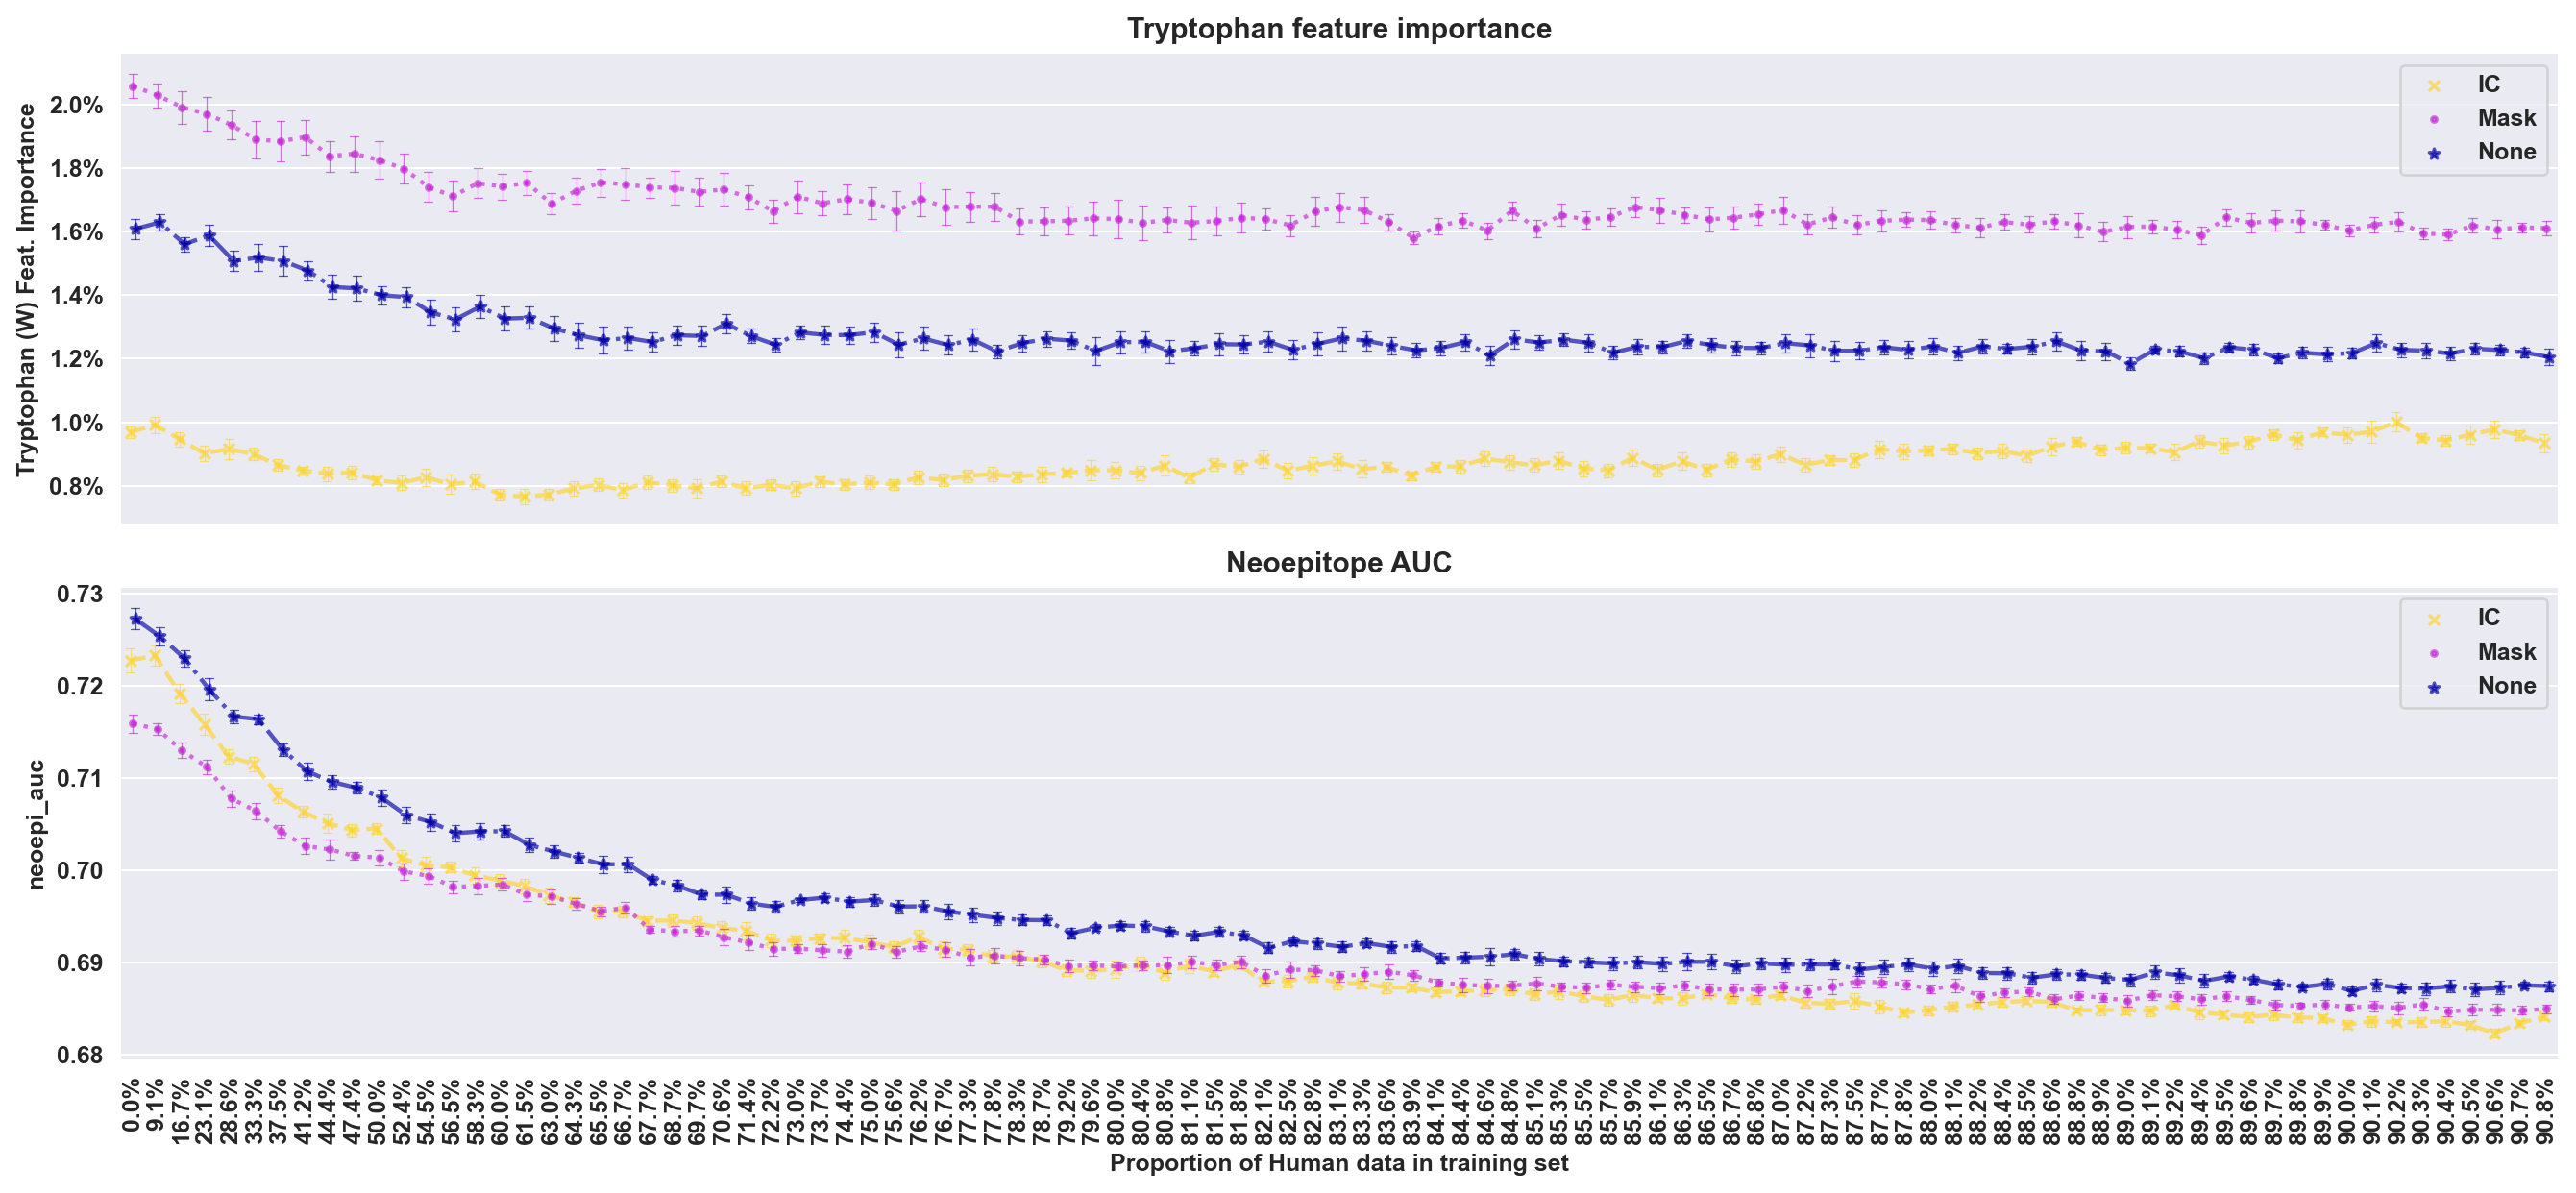

In [72]:
from src.utils import get_palette
f_human,a = plt.subplots(2,1, figsize=(15,7), sharex=True)
a = a.ravel()
sns.set_palette(get_palette('gnuplot2_r', 3))
human_df['PropViral'] = human_df['Proportion Human'].apply(lambda x: float(x[:-1]))
sns.pointplot(data=human_df, x='Proportion Human', y = 'Tryptophan (W) Feat. Importance', hue='Weight', ax=a[0],
              errorbar='se', estimator='mean', errwidth=.5, capsize=.35, dodge=0.2, scale=0.65,
              markers=['x','.','*'], linestyles=['--',':','-.'])
plt.setp(a[0].patches, alpha=0.75)
plt.setp(a[0].lines, alpha=0.65)
plt.setp(a[0].collections, alpha=0.65)
# a[0].set_yticklabels([str(round(x,2)) for x in np.arange(.8, 2.2, .2)])
sns.pointplot(data=human_df, x='Proportion Human', y = 'neoepi_auc', hue='Weight', ax=a[1],
              errorbar='se', estimator='mean', errwidth=.5, capsize=.35, dodge=0.2, scale=0.65,
              markers=['x','.','*'], linestyles=['--',':','-.'])

plt.setp(a[1].patches, alpha=0.75)
plt.setp(a[1].lines, alpha=0.65)
plt.setp(a[1].collections, alpha=0.65)
a[1].legend(loc='upper right', prop={'weight':'semibold'})#,frameon=False)
a[0].legend(loc='upper right', prop={'weight':'semibold'})
a[0].set_xlabel('')
a[1].set_xlabel('Proportion of Human data in training set', fontweight='semibold',fontsize=10)

a[1].set_xticklabels(a[1].get_xticklabels(), rotation=90, ha='center', va='top', fontweight='semibold')#, pad=.5);

vals = a[0].get_yticks()
a[0].set_yticklabels([f'{round(x,2)}%' for x in vals], fontweight='semibold');
a[1].set_yticklabels([f'{x:.2f}' for x in a[1].get_yticks()], fontweight='semibold');
a[0].set_ylabel(a[0].get_ylabel(), fontweight='semibold')
a[1].set_ylabel(a[1].get_ylabel(), fontweight='semibold')

a[0].set_title('Tryptophan feature importance', fontweight='semibold', fontsize=12)
a[1].set_title('Neoepitope AUC', fontweight='semibold', fontsize=12)
f_human.tight_layout()
# f.savefig('../../../writing/230131_cedar_paper_1/figures/230427_human_analysis', dpi=200, bbox_inches='tight')
f_human.savefig('../../../writing/230131_cedar_paper_1/submission_nar/figures_redo/231102_human_analysis_redo.png', dpi=300, bbox_inches='tight')

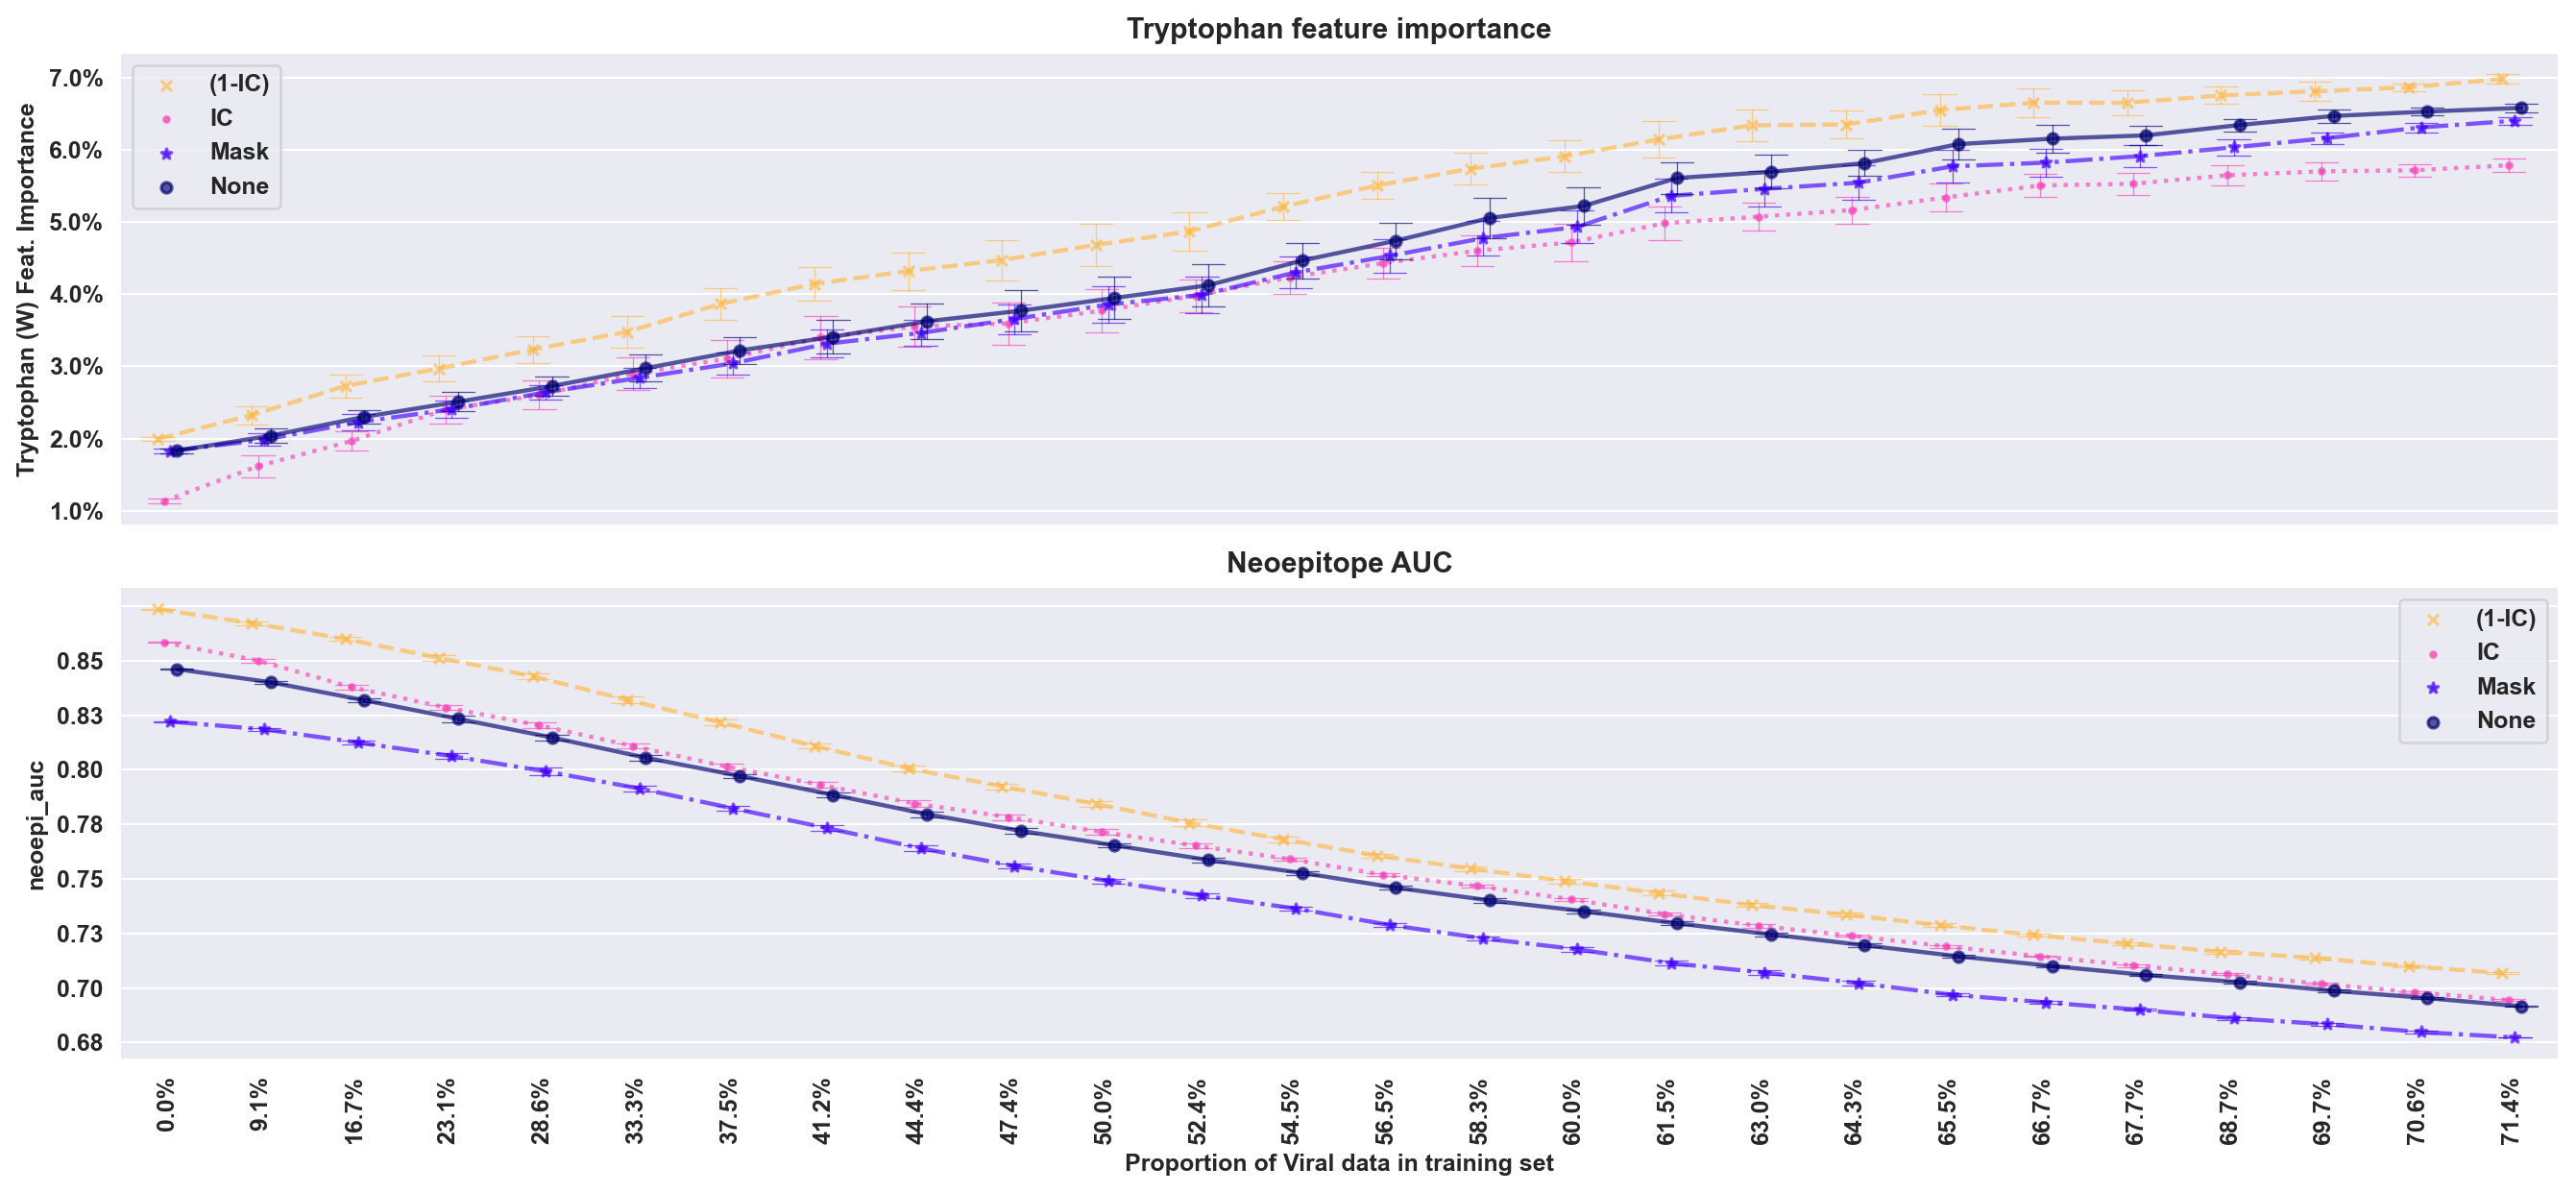

In [73]:
from src.utils import get_palette
f_viral,a = plt.subplots(2,1, figsize=(15,7), sharex=True)
a = a.ravel()
sns.set_palette(get_palette('gnuplot2_r', 4))
viral_df['PropViral'] = viral_df['Proportion Viral'].apply(lambda x: float(x[:-1]))
sns.pointplot(data=viral_df, x='Proportion Viral', y = 'Tryptophan (W) Feat. Importance', hue='Weight', ax=a[0],
              errorbar='se', estimator='mean', errwidth=.5, capsize=.35, dodge=0.2, scale=0.65,
              markers=['x','.','*', 'o'], linestyles=['--',':','-.', 'solid'])
plt.setp(a[0].patches, alpha=0.75)
plt.setp(a[0].lines, alpha=0.65)
plt.setp(a[0].collections, alpha=0.65)

sns.pointplot(data=viral_df, x='Proportion Viral', y = 'neoepi_auc', hue='Weight', ax=a[1],
              errorbar='se', estimator='mean', errwidth=.5, capsize=.35, dodge=0.2, scale=0.65,
              markers=['x','.','*', 'o'], linestyles=['--',':','-.', 'solid'])

plt.setp(a[1].patches, alpha=0.75)
plt.setp(a[1].lines, alpha=0.65)
plt.setp(a[1].collections, alpha=0.65)
a[1].legend(loc='upper right', prop={'weight':'semibold'})#,frameon=False)
a[0].legend(loc='upper left', prop={'weight':'semibold'})
a[0].set_xlabel('')
a[1].set_xlabel('Proportion of Viral data in training set', fontweight='semibold',fontsize=10)


a[1].set_xticklabels(a[1].get_xticklabels(), rotation=90, ha='center', va='top', fontweight='semibold')#, pad=.5);

vals = a[0].get_yticks()
a[0].set_yticklabels([f'{x}%' for x in vals], fontweight='semibold');
a[1].set_yticklabels([f'{x:.2f}' for x in a[1].get_yticks()], fontweight='semibold');
a[0].set_ylabel(a[0].get_ylabel(), fontweight='semibold')
a[1].set_ylabel(a[1].get_ylabel(), fontweight='semibold')

a[0].set_title('Tryptophan feature importance', fontweight='semibold', fontsize=12)
a[1].set_title('Neoepitope AUC', fontweight='semibold', fontsize=12)
f_viral.tight_layout()
# f.savefig('../../../writing/230131_cedar_paper_1/figures/230408_viral_analysis', dpi=200, bbox_inches='tight')
f_viral.savefig('../../../writing/230131_cedar_paper_1/submission_nar/figures_redo//230517_updated_viral_analysis', dpi=300, bbox_inches='tight')

In [71]:

def merge_2axes(fig1,fig2,file_name1="f1.png",file_name2="f2.png", dpi=200, pad=.1,
                final_fn = '../../../writing/230131_cedar_paper_1/figures/230517_Final_benchmark_figure_merged.png'):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom": False}
    sns.set_theme(style="ticks", rc=custom_params)
    fig1.savefig(file_name1, bbox_inches='tight', dpi= dpi)
    fig2.savefig(file_name2, bbox_inches='tight', dpi= dpi)
    
    # inherit figures' dimensions, partially
    h1, h2 = [int(np.ceil(fig.get_figheight())) for fig in (fig1, fig2)]
    wmax = int(np.ceil(max([fig.get_figwidth() for fig in (fig1, fig2)])))

    fig, axes = plt.subplots(h1 + h2, figsize=(wmax, h1 + h2))
    
    # make two axes of desired height proportion
    gs = axes[0].get_gridspec()
    for ax in axes.flat:
        ax.remove()
    ax1 = fig.add_subplot(gs[:h1])
    ax2 = fig.add_subplot(gs[h1:])
    fig.subplots_adjust(wspace=0)

    ax1.imshow(plt.imread(file_name1))
    ax2.imshow(plt.imread(file_name2))

    for ax in (ax1, ax2):
        for side in ('top', 'left', 'bottom', 'right'):
            ax.spines[side].set_visible(False)
            ax.tick_params(left=False, right=False, labelleft=False,
                     labelbottom=False, bottom=False)
    fig.tight_layout(pad=pad)
    fig.savefig(final_fn, dpi=dpi, bbox_inches='tight')
    sns.set_style('darkgrid')
    return fig 

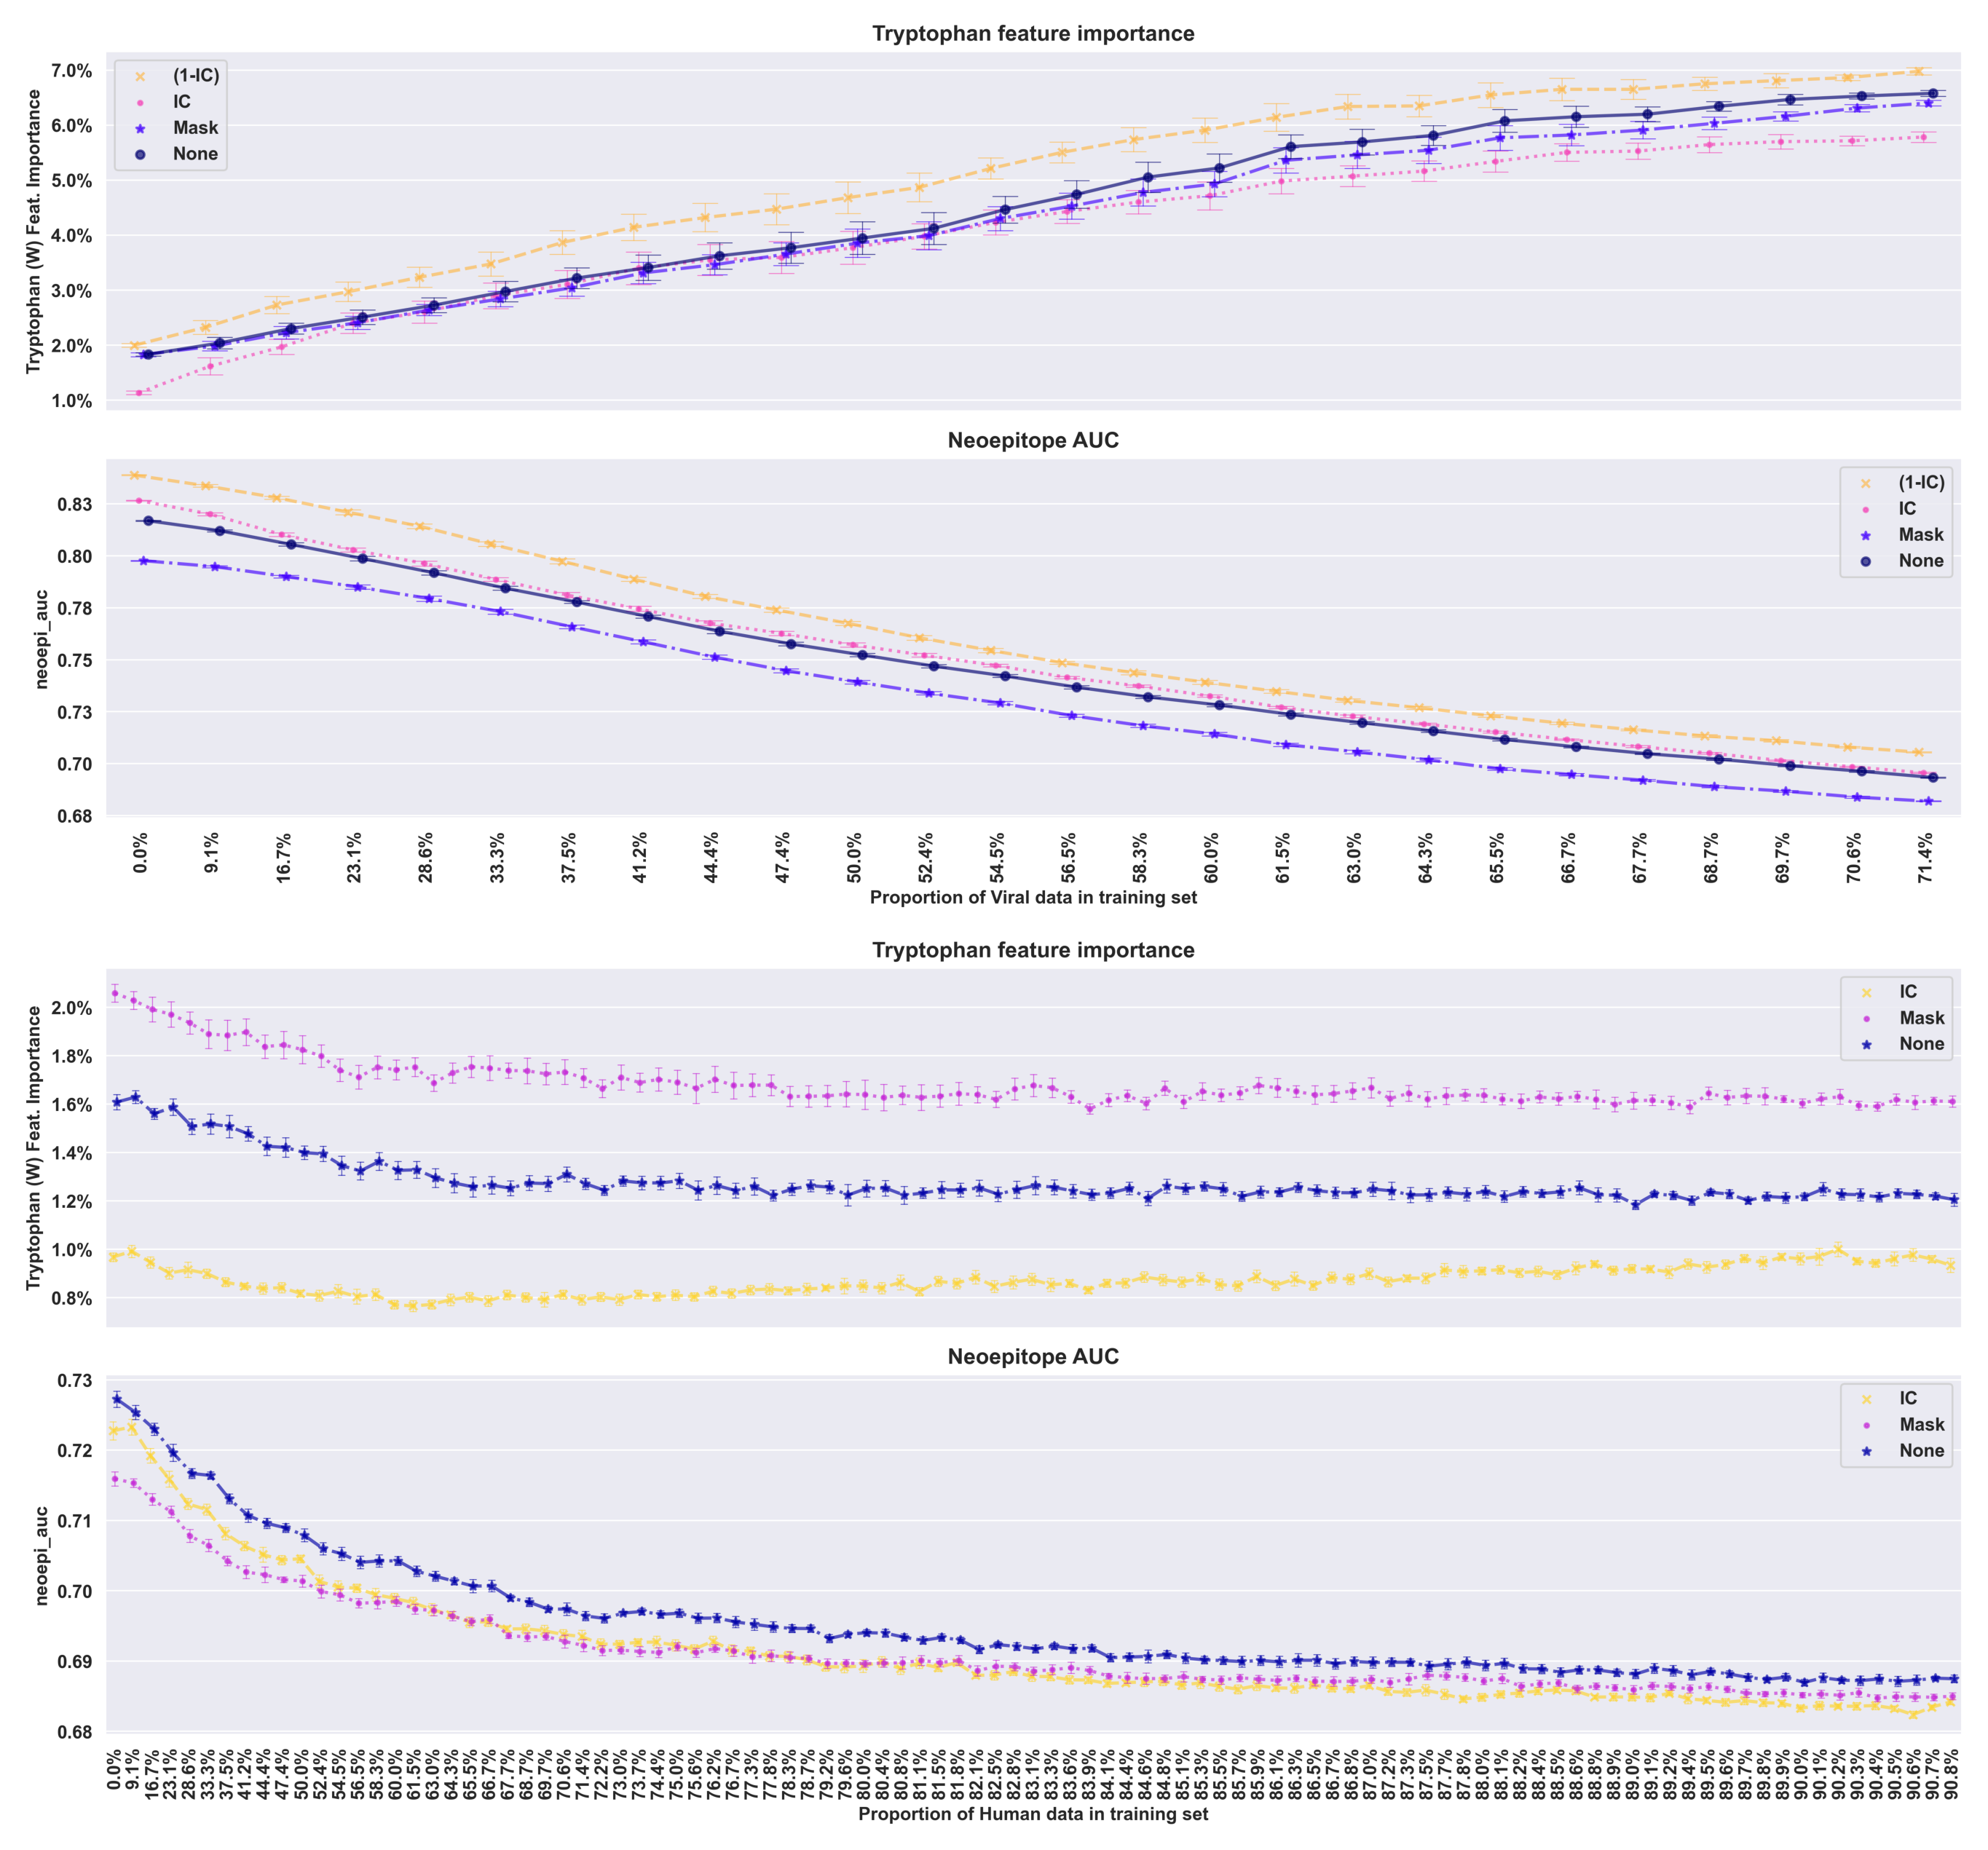

In [74]:
_ = merge_2axes(f_viral, f_human, final_fn = '../../../writing/230131_cedar_paper_1/submission_nar/figures_redo/231102_viral_human_redo.png', dpi=400)



# Redo feat imp figure

In [42]:
fi_harmonic = pd.read_csv('../output/231018_redo_merged/new_best_model/featimps_cp_merged_onehot_KL_icore_mut_boman-blsm_mut_score-Total_Gene_TPM.csv')

def rename(col):
    d = {'icore_boman':'Boman Index',
         'icore_blsm_mut_score':'BLSM Mut Score',
         'EL_rank_wt_aligned': 'WT %Rank',
         'rank': 'MUT %Rank',
         'foreignness_score': 'Foreignness',
         'Total_Gene_TPM' : 'Expression',
         'icore_dissimilarity_score':'Self-Similarity',
         'ratio_rank': 'Agretopicity'}
    if col in d.keys():
        return d[col]
    else:
        return col

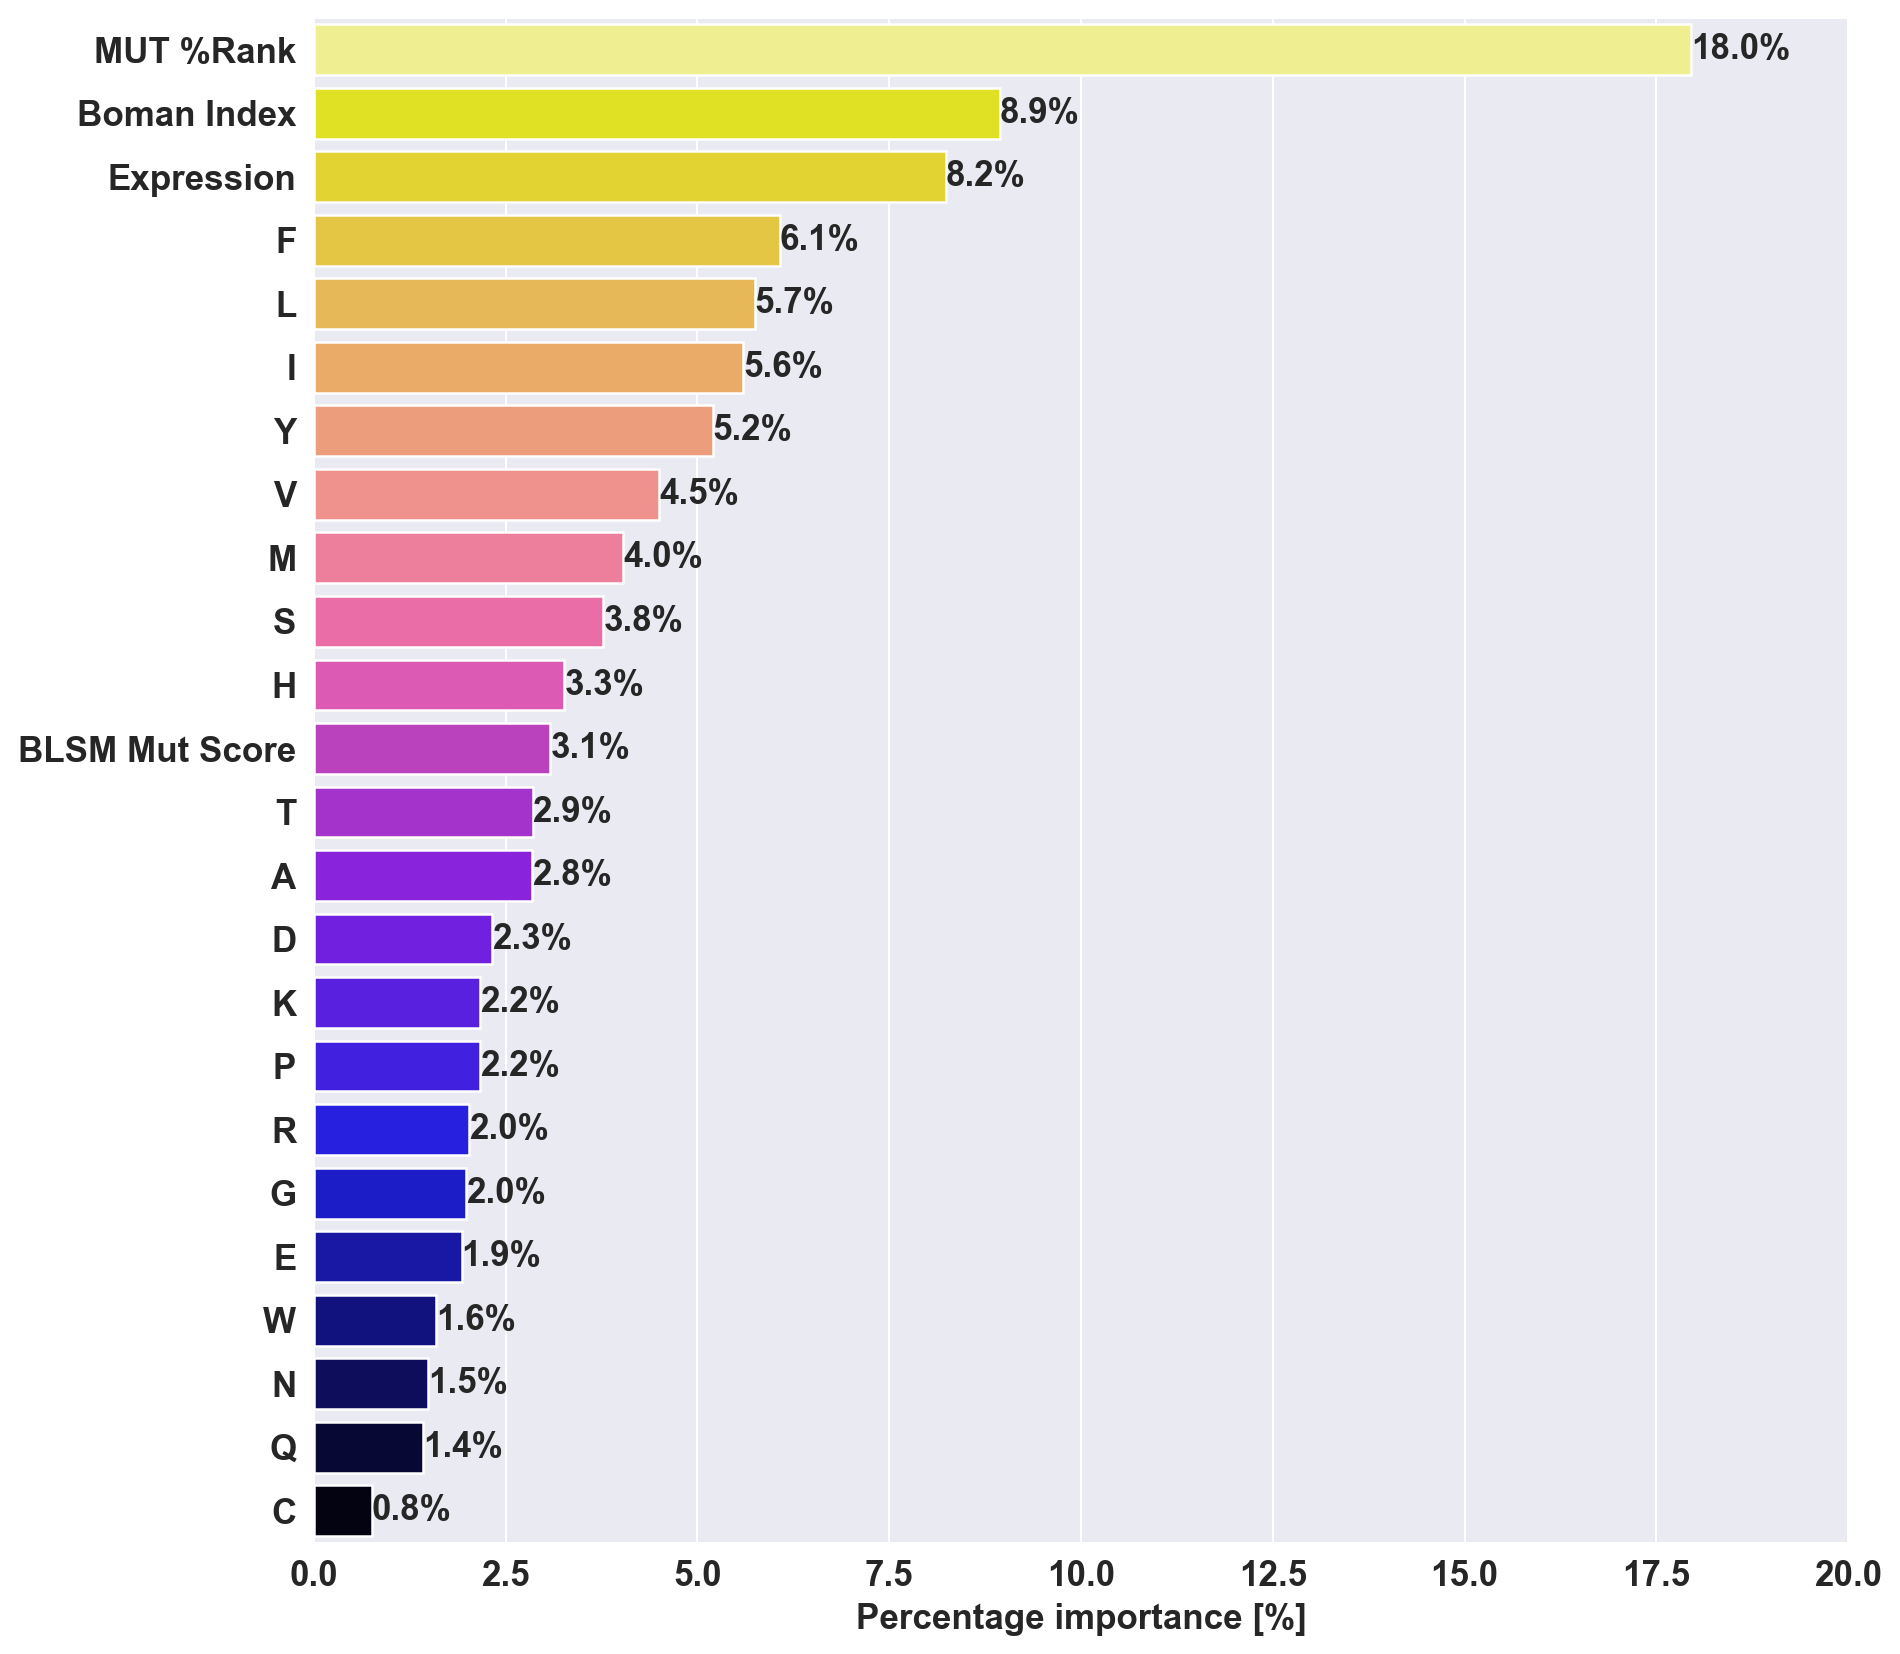

In [44]:
# Remaking bigger, only harm here
from src.metrics import plot_feature_importance
f,a = plt.subplots(1,1, figsize=(11,11.))

                        
plot_feature_importance(fi_harmonic.values.flatten(), 
                        list(map(rename,fi_harmonic.columns)), 
                        palette='gnuplot2_r', ax=a, 
                        label_number=True)
a.set_ylabel('')
a.set_xlabel('Percentage importance [%]', fontsize=14, fontweight='semibold')
a.set_yticklabels(a.get_yticklabels(), fontsize=14, fontweight='semibold')
a.set_xticklabels(a.get_xticklabels(), fontsize=14, fontweight='semibold')
a.set_xlim([0.,0.2])
f.savefig('../../../writing/230131_cedar_paper_1/submission_nar/figures_redo/FIG7_ONLYHARM_FeatImps.png', bbox_inches='tight', dpi=600)


# Redo benchmark plots with the new model

- Rebootstrap all prime filtered --> This now does NOT include the overlap with CEDAR nor PRIME for new consensus and new baseline --> Need to filter
- Rebootstrap CEDAR and NEPDB for new model + baseline (trained on merged)

In [83]:
cedar = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
nepdb = pd.read_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')

In [127]:
# Reload all old benchmarks and prep to rebootstrap after merging to new stuff
cedar_bench = pd.read_csv('../../benchmark/CEDAR_scored_withmodels.csv')
prime_bench = pd.read_csv('../../benchmark/PRIME_scored_withmodels.csv')
nepdb_bench = pd.read_csv('../../benchmark/NEPDB_scored_withmodels.csv')


In [114]:
def get_in_ref(peptide, hla, ref):
    return len(ref.query('Peptide==@peptide and HLA == @hla'))==1
cedar['in_prime'] = cedar.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], prime), axis=1)
cedar['in_nepdb'] = cedar.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], nepdb), axis=1)

prime['in_cedar'] = prime.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], cedar), axis=1)
prime['in_nepdb'] = prime.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], nepdb), axis=1)

nepdb['in_prime'] = nepdb.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], prime), axis=1)
nepdb['in_cedar'] = nepdb.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], cedar), axis=1)

In [145]:
cedar_new_best = pd.read_csv('../output/231018_redo_merged/new_best_model/CEDAR_preds_cp_merged_onehot_KL_icore_mut_boman-blsm_mut_score-Total_Gene_TPM.csv')\
                   .rename(columns = {'mean_pred': 'New Consensus'})
cedar_new_base = pd.read_csv('../output/231018_redo_merged/baseline_copy/raw/CEDAR_preds_cp_merged_onehot_None_icore_mut_only_rank.csv')\
                   .rename(columns = {'mean_pred': 'New Baseline'})

prime_new_best = pd.read_csv('../output/231018_redo_merged/new_best_model/PRIME_preds_cp_merged_onehot_KL_icore_mut_boman-blsm_mut_score-Total_Gene_TPM.csv')\
                   .rename(columns = {'mean_pred': 'New Consensus'})
prime_new_base = pd.read_csv('../output/231018_redo_merged/baseline_copy/raw/PRIME_preds_cp_merged_onehot_None_icore_mut_only_rank.csv')\
                   .rename(columns = {'mean_pred': 'New Baseline'})

nepdb_new_best = pd.read_csv('../output/231018_redo_merged/new_best_model/NEPDB_preds_cp_merged_onehot_KL_icore_mut_boman-blsm_mut_score-Total_Gene_TPM.csv')\
                   .rename(columns = {'mean_pred': 'New Consensus'})
nepdb_new_base = pd.read_csv('../output/231018_redo_merged/baseline_copy/raw/NEPDB_preds_cp_merged_onehot_None_icore_mut_only_rank.csv')\
                   .rename(columns = {'mean_pred': 'New Baseline'})



In [149]:
cols = ['HLA', 'Peptide', 'agg_label']

cedar_bench = cedar_bench.merge(cedar_new_best[cols+['New Consensus']], left_on=cols, right_on=cols, how='left')
cedar_bench = cedar_bench.merge(cedar_new_base[cols+['New Baseline']], left_on=cols, right_on=cols, how='left')

prime_bench = prime_bench.merge(prime_new_best[cols+['New Consensus']], left_on=cols, right_on=cols, how='left')
prime_bench = prime_bench.merge(prime_new_base[cols+['New Baseline']], left_on=cols, right_on=cols, how='left')

nepdb_bench = nepdb_bench.merge(nepdb_new_best[cols+['New Consensus']], left_on=cols, right_on=cols, how='left')
nepdb_bench = nepdb_bench.merge(nepdb_new_base[cols+['New Baseline']], left_on=cols, right_on=cols, how='left')


In [152]:
cedar_bench['in_prime'] = cedar_bench.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], prime), axis=1)
cedar_bench['in_nepdb'] = cedar_bench.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], nepdb), axis=1)

prime_bench['in_cedar'] = prime_bench.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], cedar), axis=1)
prime_bench['in_nepdb'] = prime_bench.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], nepdb), axis=1)

nepdb_bench['in_prime'] = nepdb_bench.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], prime), axis=1)
nepdb_bench['in_cedar'] = nepdb_bench.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], cedar), axis=1)


In [167]:
benchcols = ['Base Model', 'Optimal CEDAR Model', 'Optimal PRIME Model', 
 'New Consensus', 'PRIME_score', 'Axelf', 'IEDB_score', 'NNAlign_score_new',
 'EL_rank_mut', 'EL_rank_exp', 'mhcflurry_presentation_percentile', 
             'HLAthenaE_rank', 'foreignness_score']

rename = {'New Consensus': 'Consensus Model', 
          'EL_rank_mut': 'NetMHCpan',
          'EL_rank_exp': 'NetMHCpanExp',
          'PRIME_score': 'PRIME',
          'Axelf': 'AXEL-F',
          'IEDB_score': 'IEDB-Calis',
          'NNAlign_score_new': 'NNAlign',
          'mhcflurry_presentation_percentile':'MHCFlurry',
          'HLAthenaE_rank':'HLAthena_E',
          'foreignness_score':'ag.Foreignness'}

In [217]:
df['in_nepdb'] = df.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], nepdb), axis=1)

In [220]:
gb.set_index(['weight', 'key']).sort_values('mean_auc_KCV',ascending=False).head()

mean_auc_KCV  \
weight      key                                                                
KL          boman-blsm_mut_score-Total_Gene_TPM                     0.734019   
            boman-blsm_mut_score-foreignness_score-Total_Ge...      0.733436   
Inverted-KL boman-blsm_mut_score-foreignness_score-Total_Ge...      0.733277   
None        boman-blsm_mut_score-foreignness_score-Total_Ge...      0.733162   
KL          boman-isoelectric_point-blsm_mut_score-Total_Ge...      0.732815   

                                                                mean_auc01_KCV  \
weight      key                                                                  
KL          boman-blsm_mut_score-Total_Gene_TPM                       0.584586   
            boman-blsm_mut_score-foreignness_score-Total_Ge...        0.584568   
Inverted-KL boman-blsm_mut_score-foreignness_score-Total_Ge...        0.582199   
None        boman-blsm_mut_score-foreignness_score-Total_Ge...        0.587689   
KL          boman-isoelectric_point-blsm_mut_score-Total_Ge...        0.583590   

                                                                pval_icore_KCV  \
weight      key                                                                  
KL          boman-blsm_mut_score-Total_Gene_TPM                         0.0001   
            boman-blsm_mut_score-foreignness_score-Total_Ge...          0.0002   
Inverted-KL boman-blsm_mut_score-foreignness_score-Total_Ge...          0.0043   
None        boman-blsm_mut_score-foreignness_score-Total_Ge...          0.0000   
KL          boman-isoelectric_point-blsm_mut_score-Total_Ge...          0.0001   

                                                                pval_pep_KCV  \
weight      key                                                                
KL          boman-blsm_mut_score-Total_Gene_TPM                          0.0   
            boman-blsm_mut_score-foreignness_score-Total_Ge...           0.0   
Inverted-KL boman-blsm_mut_score-foreignness_score-Total_Ge...           0.0   
None        boman-blsm_mut_score-foreignness_score-Total_Ge...           0.0   
KL          boman-isoelectric_point-blsm_mut_score-Total_Ge...           0.0   

                                                                mean_auc_CEDAR  \
weight      key                                                                  
KL          boman-blsm_mut_score-Total_Gene_TPM                       0.734112   
            boman-blsm_mut_score-foreignness_score-Total_Ge...        0.733530   
Inverted-KL boman-blsm_mut_score-foreignness_score-Total_Ge...        0.736040   
None        boman-blsm_mut_score-foreignness_score-Total_Ge...        0.734969   
KL          boman-isoelectric_point-blsm_mut_score-Total_Ge...        0.732714   

                                                                mean_auc01_CEDAR  \
weight      key                                                                    
KL          boman-blsm_mut_score-Total_Gene_TPM                         0.581908   
            boman-blsm_mut_score-foreignness_score-Total_Ge...          0.580456   
Inverted-KL boman-blsm_mut_score-foreignness_score-Total_Ge...          0.579534   
None        boman-blsm_mut_score-foreignness_score-Total_Ge...          0.584425   
KL          boman-isoelectric_point-blsm_mut_score-Total_Ge...          0.579926   

                                                                pval_icore_CEDAR  \
weight      key                                                                    
KL          boman-blsm_mut_score-Total_Gene_TPM                           0.0000   
            boman-blsm_mut_score-foreignness_score-Total_Ge...            0.0000   
Inverted-KL boman-blsm_mut_score-foreignness_score-Total_Ge...            0.0016   
None        boman-blsm_mut_score-foreignness_score-Total_Ge...            0.0000   
KL          boman-isoelectric_point-blsm_mut_score-Total_Ge...            0.0003   

                                       

In [218]:
df.query('in_nepdb')

Empty DataFrame
Columns: [Peptide, HLA, EL_rank_mut, agg_label, fold, EL_rank_wt, EL_rank_wt_aligned, Total_Gene_TPM, Total_Peptide_TPM, Total_Scaled_Peptide_TPM, VHSE1, VHSE3, VHSE7, VHSE8, aliphatic_index, boman, core_mut, core_wt_aligned, db, foreignness_score, hydrophobicity, icore_anchor, icore_anchor_mutation, icore_blsm_mut_score, icore_dissimilarity_score, icore_len_mut, icore_len_wt, icore_mut, icore_mut_score, icore_mut_start, icore_mutation_position, icore_wt_aligned, in_cedar, in_prime, isoelectric_point, len, len_icore_mut, ratio_rank, seq_id, trueHLA_EL_rank, wild_type, icore_aliphatic_index, icore_boman, icore_hydrophobicity, icore_isoelectric_point, flag, in_nepdb]
Index: []

[0 rows x 47 columns]

In [215]:
df=pd.read_csv('../data/pepx/231018_cedar_prime_merged_fold.csv')

In [211]:
nepdb_bench.dropna(subset=['New Consensus'])

Unnamed: 0        HLA  agg_label     Peptide   wild_type   icore_mut  \
0             0  HLA-A3101          1   AFGSAHLFR   AFGSAHLYR   AFGSAHLFR   
9             9  HLA-A0101          0   ASIRNANLY   ASIRDANLY   ASIRNANLY   
20           20  HLA-A0101          0   CVDSPPPLF   CVDSPPPLS   CVDSPPPLF   
22           22  HLA-A2601          0  DLIEIFRFGY  DLIEIFRLGY  DLIEIFRFGY   
23           23  HLA-A2601          0  DMIFFSIDRY  DMISFSIDRY   MIFFSIDRY   
..          ...        ...        ...         ...         ...         ...   
225         225  HLA-A2601          0   YLIGVIGNF   YLIGVIGNS   YLIGVIGNF   
227         227  HLA-A2601          0   YMAELFSFI   YMAELFPFI   YMAELFSFI   
238         238  HLA-A2601          0   YTIEEFMEL   YTMEEFMEL   YTIEEFMEL   
242         242  HLA-A2601          0   YVKLANLSY   YVKLANLPY   YVKLANLSY   
243         243  HLA-A2601          0   YVVTISSLL   HVVTISSLL   YVVTISSLL   

      core_mut  len  EL_rank_mut  EL_rank_wt  ...   icore_exp   core_exp  \
0    AFGSAHLFR    9       0.2470      0.1952  ...   AFGSAHLFR  AFGSAHLFR   
9    ASIRNANLY    9       0.2469      0.1751  ...   ASIRNANLY  ASIRNANLY   
20   CVDSPPPLF    9       0.2420      2.2701  ...   CVDSPPPLF  CVDSPPPLF   
22   DLIEIFRGY   10       0.1187      0.0991  ...  DLIEIFRFGY  DLIEIFRGY   
23   MIFFSIDRY   10       0.1346      0.3019  ...  DMIFFSIDRY  DIFFSIDRY   
..         ...  ...          ...         ...  ...         ...        ...   
225  YLIGVIGNF    9       0.2147     11.5399  ...   YLIGVIGNF  YLIGVIGNF   
227  YMAELFSFI    9       3.5923      3.7665  ...   YMAELFSFI  YMAELFSFI   
238  YTIEEFMEL    9       0.0888      0.1655  ...   YTIEEFMEL  YTIEEFMEL   
242  YVKLANLSY    9       0.0914      0.2358  ...   YVKLANLSY  YVKLANLSY   
243  YVVTISSLL    9       0.3530      0.2708  ...   YVVTISSLL  YVVTISSLL   

     Base Model Optimal CEDAR Model  Optimal PRIME Model  Harmonic Model  \
0      0.193715            0.133486             0.251005        0.249991   
9      0.211053            0.107010             0.165493        0.159270   
20     0.216887            0.200900             0.176517        0.187529   
22     0.330625            0.372951             0.398592        0.339657   
23     0.372256            0.252956             0.293432        0.282751   
..          ...                 ...                  ...             ...   
225    0.360741            0.321674             0.229931        0.260079   
227    0.264861            0.213668             0.141165        0.143916   
238    0.460370            0.324830             0.398417        0.369767   
242    0.267640            0.198752             0.231795        0.231325   
243    0.227046            0.309598             0.176451        0.181641   

     New Consensus New Baseline  in_prime  in_cedar  
0         0.093728     0.126141     False     False  
9         0.086436     0.114155     False     False  
20        0.071200     0.122165     False     False  
22        0.202560     0.217905     False     False  
23        0.166689     0.254685     False     False  
..             ...          ...       ...       ...  
225       0.134754     0.183884     False     False  
227       0.129040     0.159005     False     False  
238       0.205838     0.325538     False     False  
242       0.129232     0.156164     False     False  
243       0.110229     0.119487     False     False  

[65 rows x 78 columns]

In [177]:
from src.bootstrap import bootstrap_eval

# Rebootstrap the stuff with the in_X filtering
cedar_bench_bs = []
prime_bench_bs = []
nepdb_bench_bs = []

for c in benchcols:
    scores = cedar_bench[c].values
    labels = cedar_bench['agg_label'].values
    bs_df=bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8, auc01=True)
    bs_df['Model'] = c if c not in rename.keys() else rename[c]
    cedar_bench_bs.append(bs_df)
    
for c in benchcols:
    scores = prime_bench.query('not in_cedar and not in_nepdb')[c].values
    labels = prime_bench.query('not in_cedar and not in_nepdb')['agg_label'].values
    bs_df=bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8, auc01=True)
    bs_df['Model'] = c if c not in rename.keys() else rename[c]
    prime_bench_bs.append(bs_df)
    
for c in benchcols:
    scores = nepdb_bench[c].values
    labels = nepdb_bench['agg_label'].values
    bs_df=bootstrap_eval(scores, labels, n_rounds=10000, n_jobs=8, auc01=True)
    bs_df['Model'] = c if c not in rename.keys() else rename[c]
    nepdb_bench_bs.append(bs_df)

    
    

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [224]:
prime_preds = pd.read_csv('../output/231018_redo_merged/new_best_model/PRIME_preds_cp_merged_onehot_KL_icore_mut_boman-blsm_mut_score-Total_Gene_TPM.csv')


In [226]:
roc_auc_score(prime_preds['agg_label'], prime_preds['mean_pred'])


0.7169553722720127

In [227]:
prime_preds['in_cedar'] = prime_preds.apply(lambda x: get_in_ref(x['Peptide'], x['HLA'], cedar), axis=1)

roc_auc_score(prime_preds.query('not in_cedar')['agg_label'], prime_preds.query('not in_cedar')['mean_pred'])

0.6260438413361169

In [179]:
cedar_bench_bs = pd.concat(cedar_bench_bs)
prime_bench_bs = pd.concat(prime_bench_bs)
nepdb_bench_bs = pd.concat(nepdb_bench_bs)

In [180]:
cedar_bench_bs.to_csv('../../benchmark/results/231106_cedar_bench_bs_redo.csv', index=False)
prime_bench_bs.to_csv('../../benchmark/results/231106_prime_bench_bs_redo.csv', index=False)
nepdb_bench_bs.to_csv('../../benchmark/results/231106_nepdb_bench_bs_redo.csv', index=False)

In [195]:
def add_vertical_label(df, order, column, axis, height=None, fontsize=12, fontweight='semibold'):
    
    tmp = df.groupby(['Model']).agg(mean=(column, 'mean'), std = (column, 'std')).reindex(order)
    xs = range(len(order))
    values = tmp['mean'].values.flatten()
    
    stds = tmp['std'].values.flatten()
    ys = values /2
    
    for i, (x, y, value, std) in enumerate(zip(xs, ys, values, stds)):
        # c = 'k' if i < len(xs)//2 else 'w'
        c='k'
        # height = value+2*std 
        height = y if height is None else height
        axis.text(x, height, f'{value:.3f}\n± {std:.3f}', ha='center', va='center',
                  fontweight=fontweight, fontsize=fontsize, color=c)
    
    
def add_horizontal_label(df, order, column, axis, length=None, fontsize=12, fontweight='semibold'):
    tmp = df.reindex(order)
    ys = range(len(order))
    values = tmp[f'mean_{column}'].values.flatten()
    stds = tmp[f'std_{column}'].values.flatten()
    xs = values / 2
    
    for i, (x, y, value, std) in enumerate(zip(xs, ys, values, stds)):
        
        length = x if length is None else length
        # c = 'k' if i< len(ys)//2 else 'w'
        c = 'k'
        axis.text(length, y, f'{value:.3f}\n± {std:.3f}', ha='center', va='center', 
                  fontweight=fontweight, fontsize=fontsize, color=c)

In [199]:
def rename_order(c, rename):
    return c if c not in rename.keys() else rename[c]
rename['Base Model']='Baseline Model'
order = [rename_order(x, rename) for x in benchcols]

In [233]:
mcs = []
prefix=''
cols_ = [f'{prefix}aliphatic_index', f'{prefix}boman', f'{prefix}hydrophobicity',
         f'{prefix}isoelectric_point','icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank',
         'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM']

for L in range(0, len(cols_) + 1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))

key=['-'.join(x) for x in mcs]
key.index('boman-icore_blsm_mut_score-Total_Gene_TPM')

113

In [237]:
prime.query('not in_cedar and not in_nepdb').groupby('agg_label').count()

HLA  fold  Peptide  wild_type  icore_mut  core_mut   len  \
agg_label                                                              
0          2395  2395     2395       2395       2395      2395  2395   
1            36    36       36         36         36        36    36   

           EL_rank_mut  EL_rank_wt  trueHLA_EL_rank  ...  \
agg_label                                            ...   
0                 2395        2395             2395  ...   
1                   36          36               36  ...   

           Total_Scaled_Peptide_TPM  Total_Gene_TPM  foreignness_score  \
agg_label                                                                
0                              2395            2395               2395   
1                                36              36                 36   

           ratio_rank  ic_len  expanded_input  ratio_rank_squared  in_cedar  \
agg_label                                                                     
0                2395    2395            2395                2395      2395   
1                  36      36              36                  36        36   

           in_nepdb  missing_bench  
agg_label                           
0              2395           2395  
1                36             36  

[2 rows x 43 columns]

In [234]:
gb.sort_values('mean_auc_PRIME',ascending=False).head()

weight                                                key  \
506   KL-Mask    blsm_mut_score-foreignness_score-Total_Gene_TPM   
3504  KL-Mask  hydrophobicity-blsm_mut_score-ratio_rank-EL_ra...   
3724  KL-Mask                      blsm_mut_score-Total_Gene_TPM   
4668  KL-Mask  hydrophobicity-blsm_mut_score-ratio_rank-EL_ra...   
2270  KL-Mask  blsm_mut_score-ratio_rank-foreignness_score-To...   

      mean_auc_KCV  mean_auc01_KCV  pval_icore_KCV  pval_pep_KCV  \
506       0.724178        0.578697          0.0313        0.0003   
3504      0.715862        0.580547          0.3043        0.0035   
3724      0.723555        0.578997          0.0371        0.0003   
4668      0.724309        0.581354          0.0277        0.0001   
2270      0.718586        0.578137          0.1881        0.0039   

      mean_auc_CEDAR  mean_auc01_CEDAR  pval_icore_CEDAR  pval_pep_CEDAR  ...  \
506         0.719696          0.570422            0.1146          0.0001  ...   
3504        0.716361          0.583068            0.2239          0.0002  ...   
3724        0.718335          0.571501            0.1593          0.0003  ...   
4668        0.724367          0.580467            0.0286          0.0000  ...   
2270        0.714605          0.568365            0.3416          0.0017  ...   

      pval_icore_PRIME  pval_pep_PRIME  mean_auc_NEPDB  mean_auc01_NEPDB  \
506             0.0377          0.0095        0.796937          0.671514   
3504            0.0228          0.0066        0.736676          0.610757   
3724            0.0449          0.0103        0.804353          0.680651   
4668            0.0504          0.0101        0.784227          0.656973   
2270            0.0543          0.0132        0.799721          0.670542   

      pval_icore_NEPDB  pval_pep_NEPDB  mean_auc_NEW_NEPDB  \
506             0.0286          0.0001            0.630213   
3504            0.8794          0.0134            0.534725   
3724            0.0091          0.0000            0.636385   
4668            0.0827          0.0002            0.614999   
2270            0.0196          0.0001            0.622644   

      mean_auc01_NEW_NEPDB  pval_icore_NEW_NEPDB  pval_pep_NEW_NEPDB  
506               0.603221                0.0009              0.0048  
3504              0.497617                0.2190              0.1373  
3724              0.603198                0.0008              0.0041  
4668              0.562732                0.0010              0.0069  
2270              0.565253                0.0027              0.0099  

[5 rows x 22 columns]

In [206]:
prime_bench_bs.groupby(['Model']).agg(mean_auc = ('auc','mean'))

mean_auc
Model                        
AXEL-F               0.391704
Base Model           0.647071
Consensus Model      0.616116
HLAthena_E           0.431945
IEDB-Calis           0.628043
MHCFlurry            0.346562
NNAlign              0.641776
NetMHCpan            0.397464
NetMHCpanExp         0.392953
Optimal CEDAR Model  0.614579
Optimal PRIME Model  0.676724
PRIME                0.703600
foreignness_score    0.506984

In [207]:
nepdb_bench_bs.groupby(['Model']).agg(mean_auc = ('auc','mean'))

mean_auc
Model                        
AXEL-F               0.753817
Base Model           0.728627
HLAthena_E           0.279186
IEDB-Calis           0.468376
MHCFlurry            0.315379
NNAlign              0.425952
NetMHCpan            0.279544
NetMHCpanExp         0.284147
Optimal CEDAR Model  0.733268
Optimal PRIME Model  0.796303
PRIME                0.541390
foreignness_score    0.507705

In [200]:
bench = pd.concat([cedar_bench_bs.assign(evalset='cedar'.upper()), 
                   prime_bench_bs.assign(evalset='prime'.upper()), 
                   nepdb_bench_bs.assign(evalset='nepdb'.upper())])

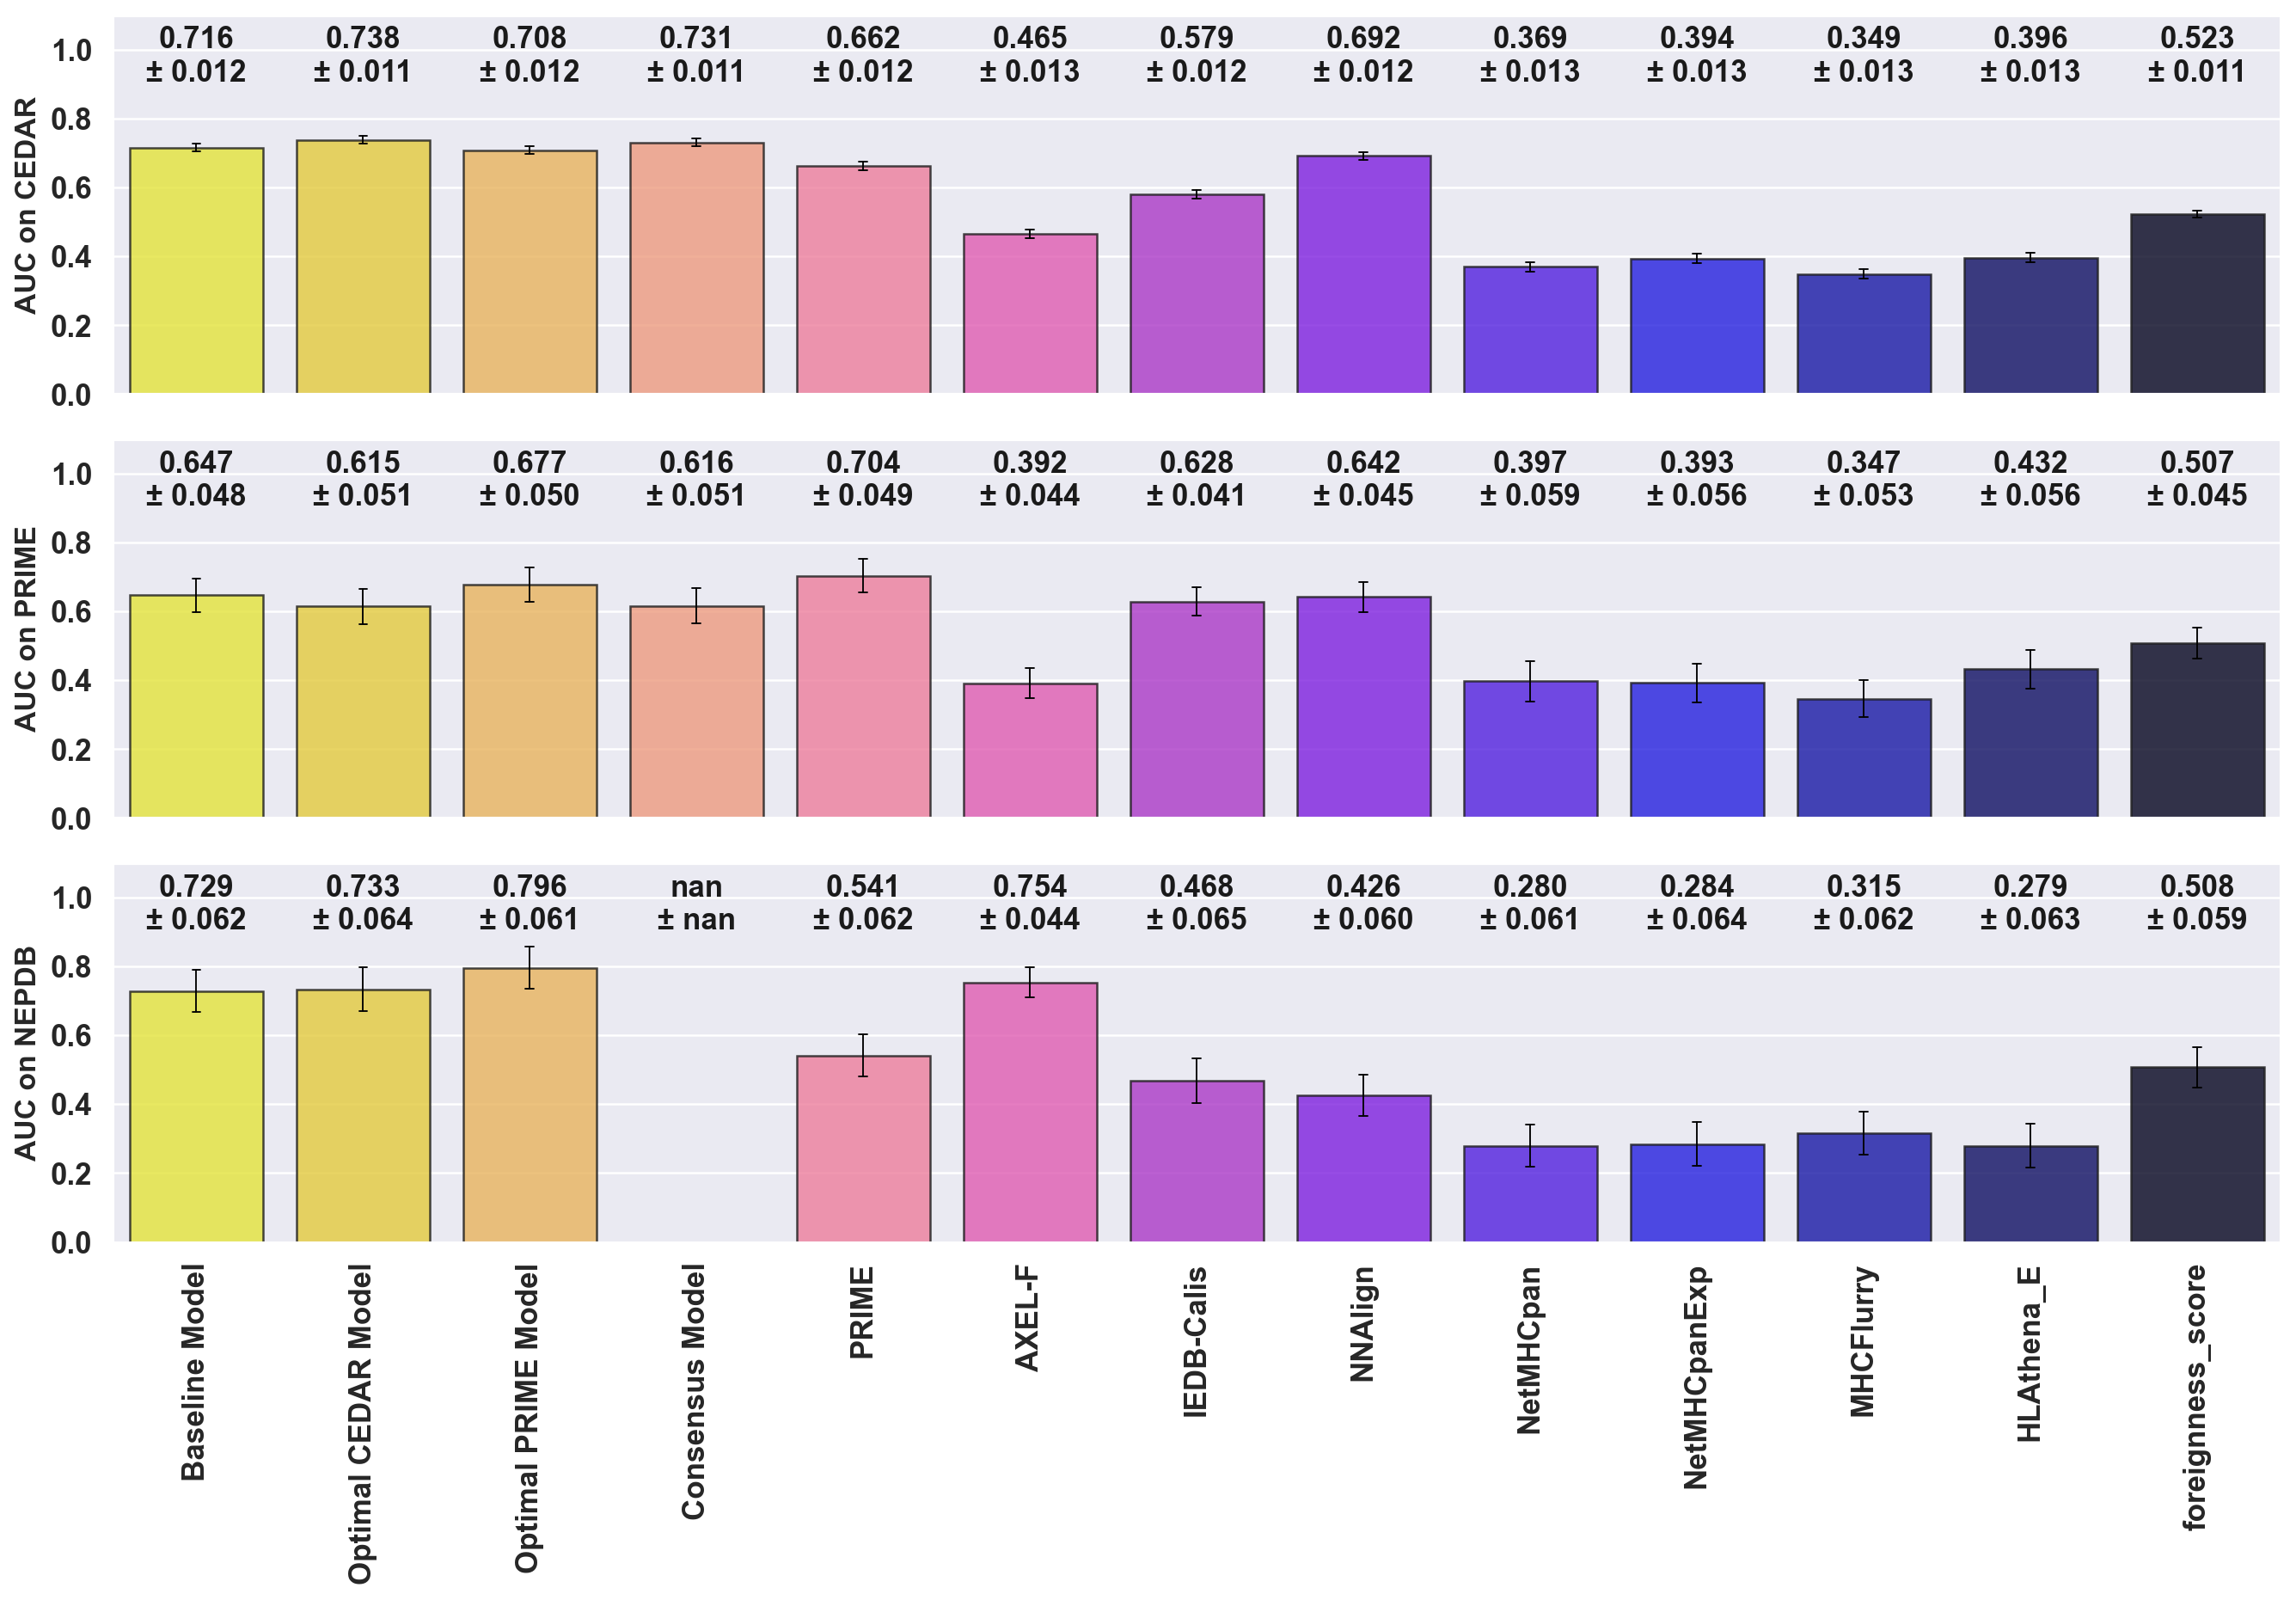

In [201]:
sns.set_theme()
# INDIVIDUAL VERTICAL BARPLOTS
bench.replace({'NNAlign_New':'NNAlign', 'AntigenGarnish_foreignness':'ag.Foreignness', 
               'Harmonic Model':'Consensus Model', 'Base Model': 'Baseline Model'}, inplace=True)
colors = {k:v for k,v in zip(get_palette('gnuplot2_r', len(order)), order)}
sns.set_palette(get_palette('gnuplot2_r',len(order)))
f1, a1 = plt.subplots(3,1, figsize=(15, 10.5), sharex=True)
a1 = a1.ravel()

bench.rename(columns={'condition':'Model'}, inplace=True)
for evalset, axis in zip([ 'CEDAR', 'PRIME', 'NEPDB'], a1):
    tmp = bench.query('evalset==@evalset')
    sns.barplot(tmp, x='Model', y='auc', errorbar='sd', order = order, ax=axis, capsize=.05, errwidth=0.75, errcolor='.0')
    plt.setp(axis.patches, edgecolor='k', linewidth=1., alpha=0.8)
    # axis.set_title(f'{evalset}', fontweight='semibold', fontsize=14)
    axis.set_ylabel(f'AUC on {evalset}', fontweight='semibold', fontsize=13.5)
    axis.set_ylim([0,1.1])
    axis.set_yticklabels(#axis.get_yticklabels(),#[f'0.{x}' for x in range(10)],
                         ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], 
                         fontweight='semibold', fontsize=14)
    add_vertical_label(tmp, order, 'auc', axis, height= .98, fontweight='semibold', fontsize=14)
a1[0].set_xlabel('')
a1[1].set_xlabel('')
a1[2].set_xlabel('', fontweight='semibold', fontsize=14)
a1[2].set_xticklabels(a1[2].get_xticklabels(), rotation=90, ha='center', fontweight='semibold', fontsize=14)
f1.tight_layout()
f1.savefig('../../../writing/230131_cedar_paper_1/submission_nar/figures_redo//FIG-1_top_panel_AUCs.png', 
           dpi=600, bbox_inches='tight')


In [171]:
concat = benchmark.groupby(['evalset','Model']).agg(mean_auc=('auc','mean'),
                                                    mean_auc01=('auc_01','mean')).reset_index()\
           .melt(id_vars = ['evalset', 'Model'], value_vars=['mean_auc', 'mean_auc01'])\
            .query('Model!="mhcflurry_affinity_percentile"')
concat.head()

evalset           Model  variable     value
0   CEDAR          AXEL-F  mean_auc  0.467250
1   CEDAR      Base Model  mean_auc  0.716925
2   CEDAR      HLAthena_E  mean_auc  0.601996
3   CEDAR  Harmonic Model  mean_auc  0.716358
4   CEDAR      IEDB-Calis  mean_auc  0.577859

In [172]:
def flatten_columns(multi_index:tuple):
    return ''.join(multi_index).replace('value','')
pivot = pd.pivot(concat, index= ['evalset', 'Model'],columns = ['variable'], values=['value'])
pivot.columns = map(flatten_columns, pivot.columns)
pivot.reset_index(inplace=True)
pivot.head()

evalset           Model  mean_auc  mean_auc01
0   CEDAR          AXEL-F  0.467250    0.502176
1   CEDAR      Base Model  0.716925    0.580761
2   CEDAR      HLAthena_E  0.601996    0.530867
3   CEDAR  Harmonic Model  0.716358    0.568512
4   CEDAR      IEDB-Calis  0.577859    0.510408

In [173]:
def get_measure(row, metric):
    return row[f'std_{metric}'] / ((row[f'max_{metric}'] - row[f'min_{metric}']) / row[f'mean_{metric}'])

def get_measure2(row, metric):
    return ((row[f'max_{metric}'] - row[f'min_{metric}']) / row[f'mean_{metric}'])
pivot_gb = pivot.groupby(['Model']).agg(max_auc = ('mean_auc', 'max'), min_auc = ('mean_auc', 'min'), std_auc = ('mean_auc', 'std'), mean_auc = ('mean_auc', 'mean'),
                              max_auc01 = ('mean_auc01', 'max'), min_auc01 = ('mean_auc01', 'min'), std_auc01 = ('mean_auc01', 'std'), mean_auc01 = ('mean_auc01', 'mean'))

pivot_gb['auc_measure'] = pivot_gb.apply(get_measure2, metric='auc', axis=1)
pivot_gb['auc01_measure'] = pivot_gb.apply(get_measure2, metric='auc01', axis=1)

pivot_gb['auc_measure_squared'] = pivot_gb['auc_measure']**2
pivot_gb['auc01_measure_squared'] = pivot_gb['auc01_measure']**2


pivot_gb['auc_dispersion_measure'] = pivot_gb['auc_measure'] * pivot_gb['std_auc']
pivot_gb['auc01_dispersion_measure'] = pivot_gb['auc01_measure'] * pivot_gb['std_auc01']
pivot_gb.reset_index(inplace=True)
pivot_gb = pivot_gb.rename(columns={'Method':'Model'}).replace({'NNAlign_New':'NNAlign', 'AntigenGarnish_foreignness':'ag.Foreignness'}).set_index('Model')

pivot_gb

max_auc   min_auc   std_auc  mean_auc  max_auc01  \
Model                                                                    
AXEL-F               0.776611  0.433613  0.189069  0.559158   0.547054   
Base Model           0.735294  0.693002  0.021207  0.715074   0.580761   
HLAthena_E           0.729419  0.601996  0.071605  0.646839   0.618156   
Harmonic Model       0.805814  0.716358  0.050411  0.747661   0.658602   
IEDB-Calis           0.591911  0.480349  0.060761  0.550040   0.510408   
MHCflurry            0.672032  0.646390  0.013872  0.662269   0.561388   
NNAlign              0.692995  0.445502  0.128912  0.590105   0.550419   
NetMHCpan            0.652477  0.590433  0.032080  0.616737   0.553196   
NetMHCpanExp         0.720480  0.601480  0.061168  0.652790   0.615840   
Optimal CEDAR Model  0.740732  0.654020  0.049500  0.711166   0.586369   
Optimal PRIME Model  0.806062  0.710319  0.052374  0.745925   0.657511   
PRIME                0.709605  0.554861  0.079084  0.641683   0.581538   
ag.Foreignness       0.523740  0.501314  0.011411  0.513749   0.514364   

                     min_auc01  std_auc01  mean_auc01  auc_measure  \
Model                                                                
AXEL-F                0.473684   0.036988    0.507638     0.613419   
Base Model            0.558161   0.011398    0.570325     0.059143   
HLAthena_E            0.530867   0.047462    0.563744     0.196993   
Harmonic Model        0.568512   0.045796    0.608788     0.119648   
IEDB-Calis            0.473861   0.018304    0.491524     0.202824   
MHCflurry             0.540050   0.010787    0.549801     0.038720   
NNAlign               0.474078   0.039757    0.518667     0.419405   
NetMHCpan             0.538465   0.007537    0.544909     0.100601   
NetMHCpanExp          0.538680   0.041200    0.568913     0.182295   
Optimal CEDAR Model   0.530897   0.028022    0.560940     0.121929   
Optimal PRIME Model   0.568192   0.044695    0.613887     0.128354   
PRIME                 0.512883   0.034623    0.544606     0.241153   
ag.Foreignness        0.508638   0.003210    0.512338     0.043652   

                     auc01_measure  auc_measure_squared  \
Model                                                     
AXEL-F                    0.144531             0.376283   
Base Model                0.039625             0.003498   
HLAthena_E                0.154838             0.038806   
Harmonic Model            0.147982             0.014316   
IEDB-Calis                0.074355             0.041138   
MHCflurry                 0.038810             0.001499   
NNAlign                   0.147189             0.175900   
NetMHCpan                 0.027035             0.010121   
NetMHCpanExp              0.135626             0.033231   
Optimal CEDAR Model       0.098891             0.014867   
Optimal PRIME Model       0.145497             0.016475   
PRIME                     0.126065             0.058155   
ag.Foreignness            0.011177             0.001905   

                     auc01_measure_squared  auc_dispersion_measure  \
Model                                                                
AXEL-F                            0.020889                0.115979   
Base Model                        0.001570                0.001254   
HLAthena_E                        0.023975                0.014106   
Harmonic Model                    0.021899                0.006032   
IEDB-Calis                        0.005529                0.012324   
MHCflurry                         0.001506                0.000537   
NNAlign                           0.021664                0.054066   
NetMHCpan                         0.000731                0.003227   
NetMHCpanExp                      0.018395                0.011151   
Optimal CEDAR Model               0.009779                0.006035   
Optimal PRIME Model               0.021169                0.006722   
PRIME                             0.015892                0.0190

NameError: name 'pivot_gb' is not defined

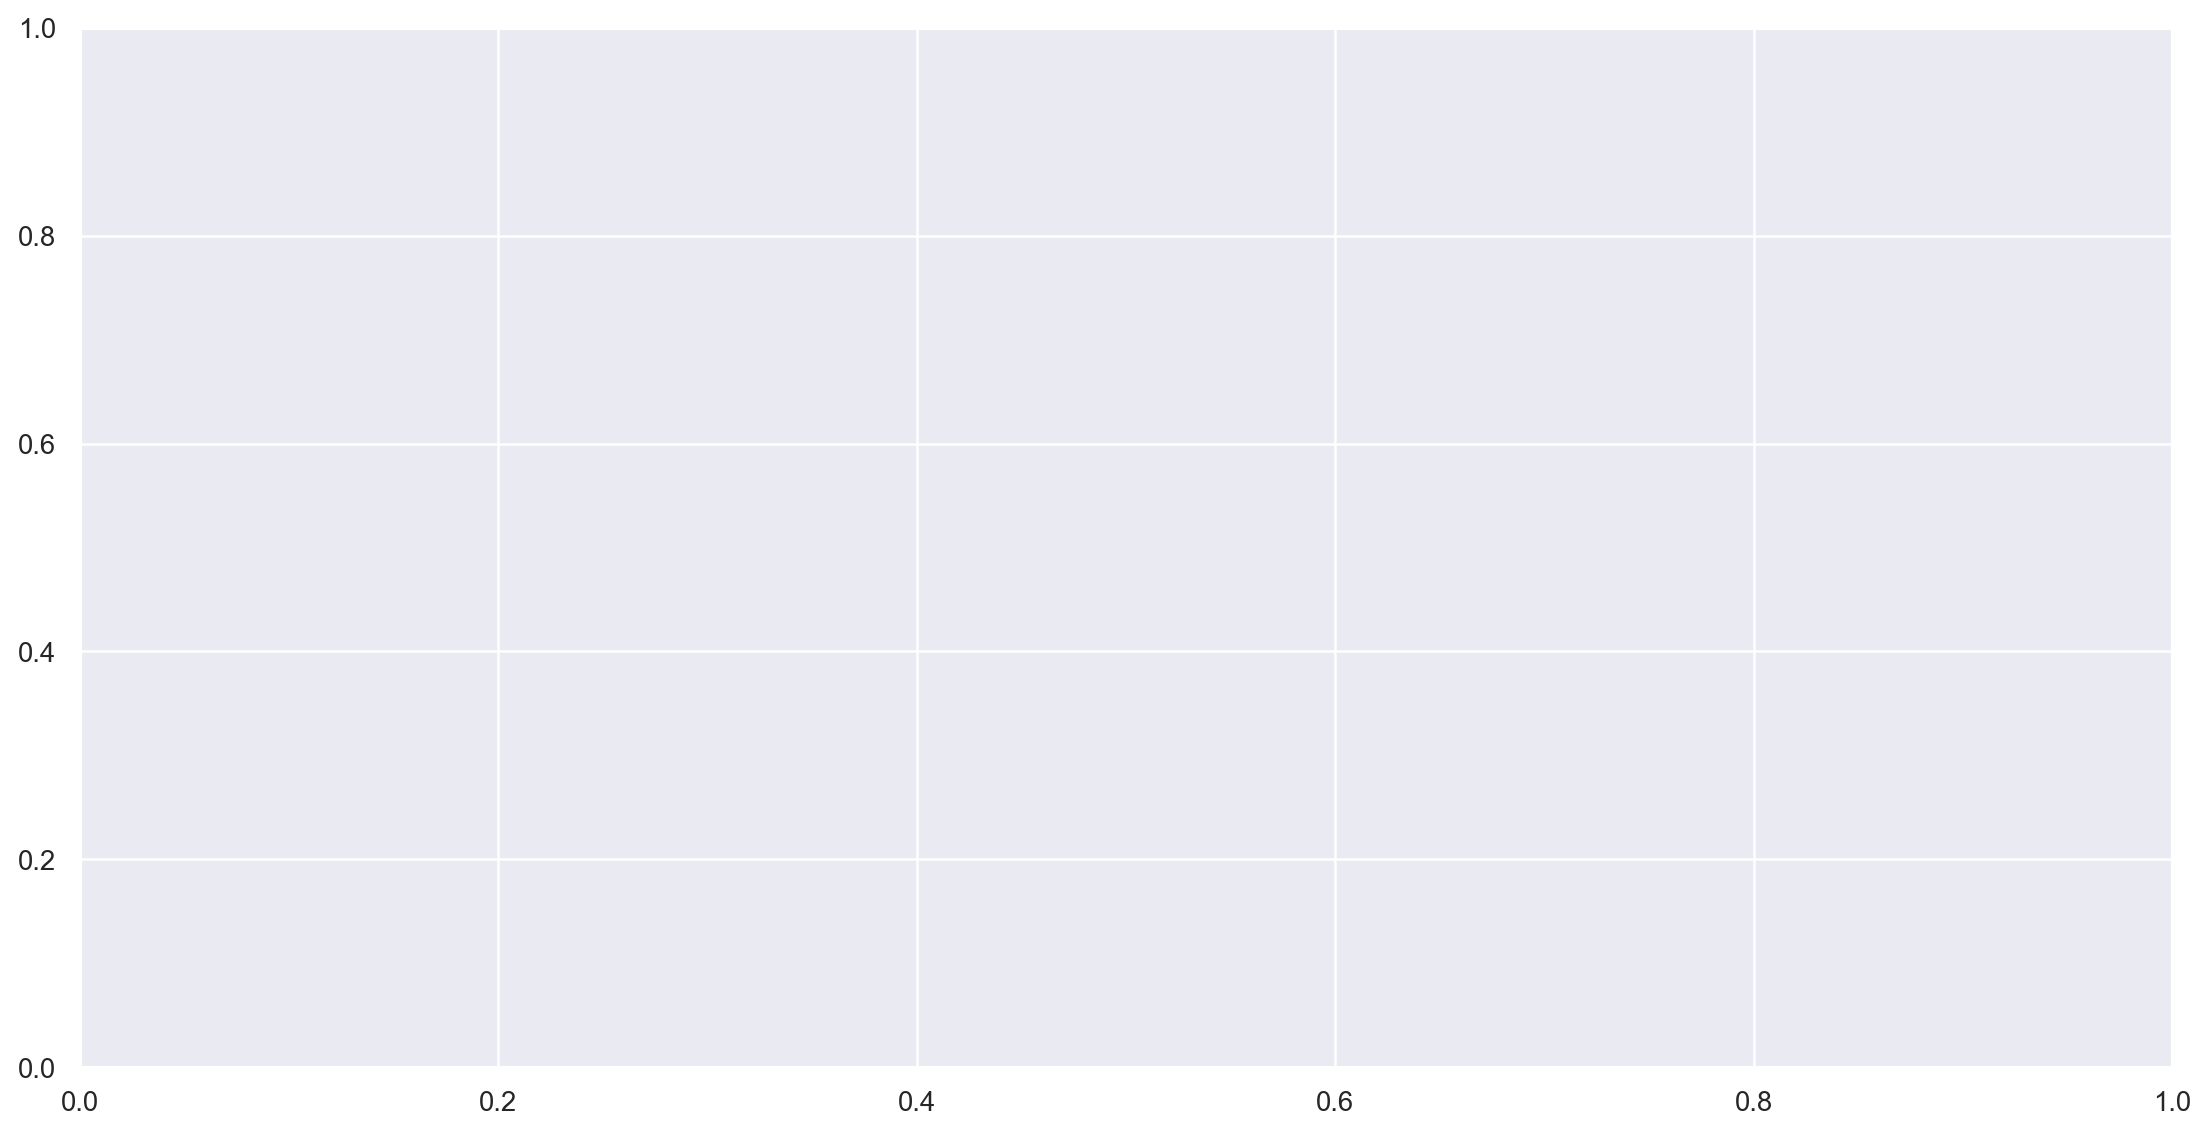

In [202]:
# Here remake the horizontal plot with only AUC (and not AUC 01, so single panel)
# MEAN HORIZONTAL BARPLOTS
f_bot,a_bot = plt.subplots(1,1, figsize=(15,7.5), sharex=True)
sns.set_theme()
sns.set_style('darkgrid')
sns.set_palette(get_palette('gnuplot2_r', len(order)))

tmp_pivot = pivot_gb.reset_index().replace({'Base Model': 'Baseline Model','Harmonic Model':'Consensus Model'}).set_index('Model')
sns.barplot(tmp_pivot.reset_index(), y='Model', x='mean_auc',ax=a_bot, 
            xerr = tmp_pivot.reindex(order)['std_auc'], errorbar=None,
            error_kw={'capsize':2, 'capthick': .75, 'linewidth':.75,}, order = order)


plt.setp(a_bot.patches, edgecolor='k',  linewidth= 1., alpha=0.8)

# f2.suptitle('Using standard deviation as E-bars', fontweight='semibold', fontsize=16)
# a_bot.set_title('Mean AUC', fontweight='semibold', fontsize=14)
a_bot.set_ylabel('', fontweight='semibold', fontsize=14)
a_bot.set_yticklabels(a_bot.get_yticklabels(), fontweight='semibold',fontsize=14)
a_bot.set_xlim([0, .9])
a_bot.set_xlabel('Mean AUC', fontweight='semibold', fontsize=14)
a_bot.set_xticklabels([f'0.{x}' for x in range(10)], fontweight='semibold', fontsize=14)
add_horizontal_label(tmp_pivot, order, 'auc', a_bot, length=.85, fontsize=14, fontweight='semibold')
# add_horizontal_label(pivot_gb, order, 'auc01', a2[1], length=.85)
f_bot.tight_layout()
f_bot.savefig('../../../writing/230131_cedar_paper_1/submission_nar/figures_redo/FIG-1_bot_panel_mean_barplots.png', 
              dpi=600, bbox_inches='tight')


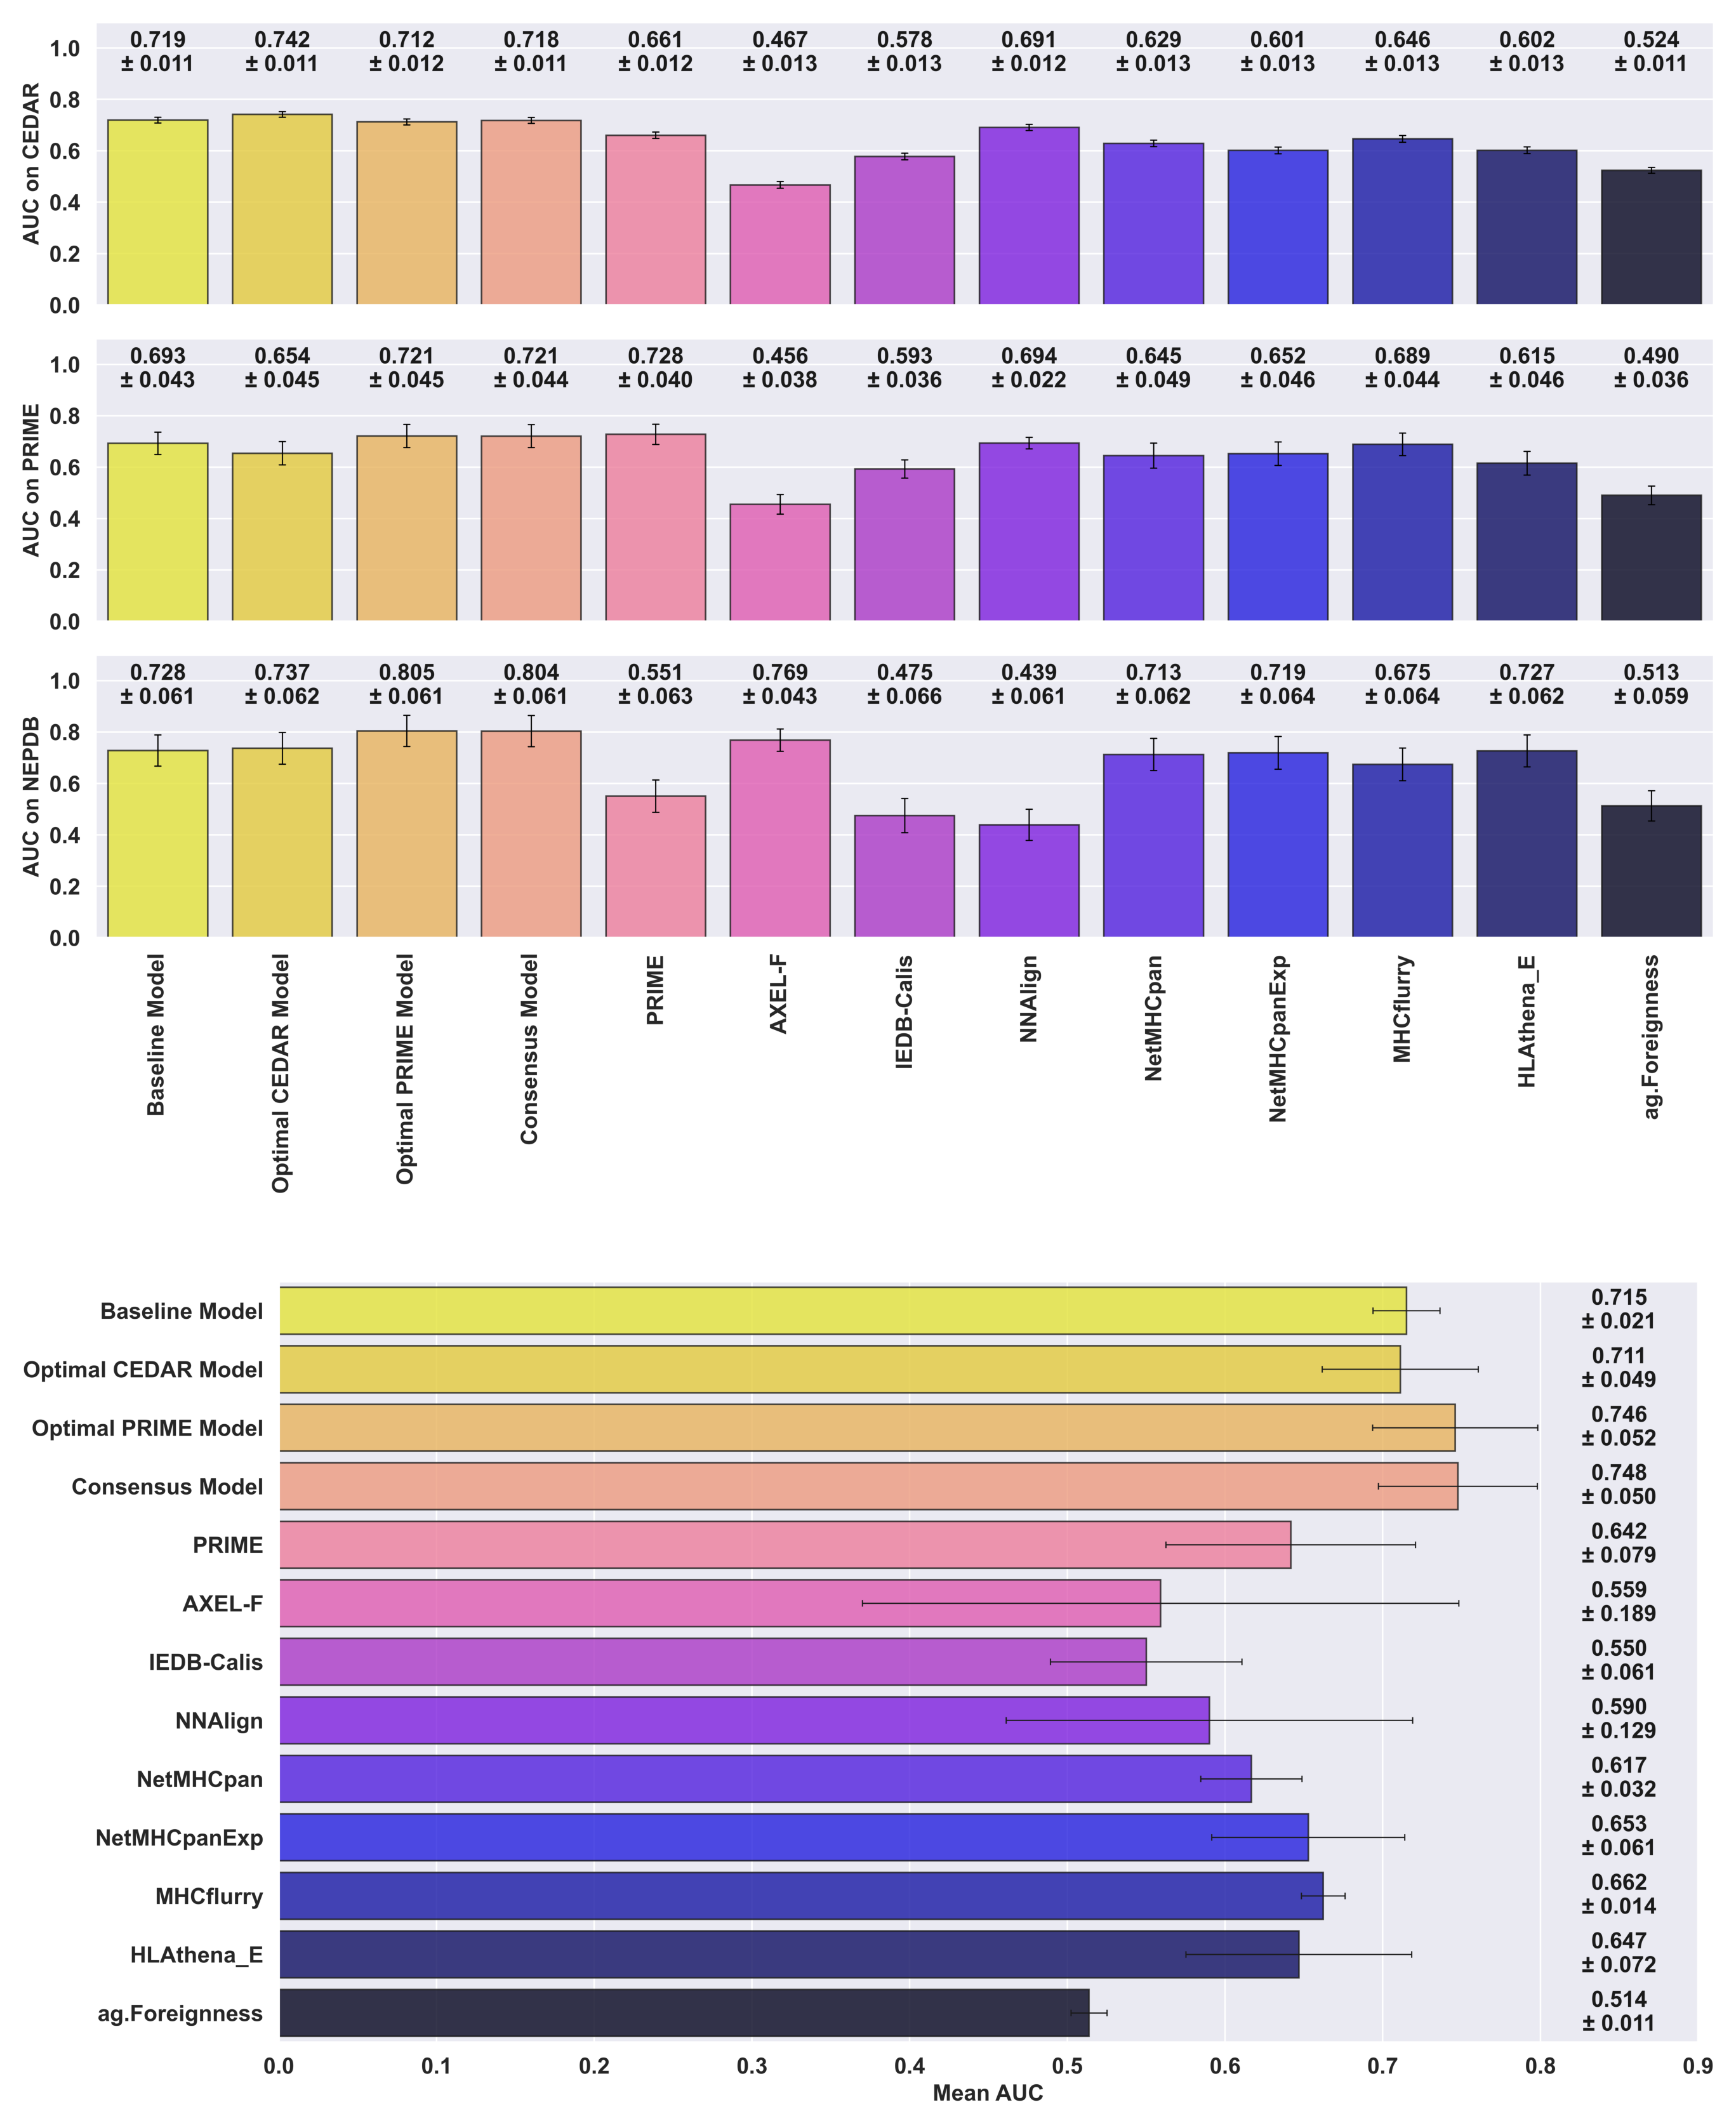

In [179]:
_=merge_2axes(f1, f_bot, pad=0.001, dpi = 600,
              final_fn='../../../writing/230131_cedar_paper_1/figures_FixSizing/FIG-1_merged_final.png')